<a href="https://colab.research.google.com/github/farrelrassya/teachingMLDL/blob/main/02.%20Deep%20Learning/01.%20Week%201/Notebooks/06.learning_rate_schedulers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Rate Schedulers Deep Dive

## The Art of Adapting Learning Rates During Training

---

**Course**: Deep Learning  
**Topic**: Learning Rate Scheduling - Step Decay, Exponential Decay, Cosine Annealing, Warmup & More  

---

### Learning Objectives

By the end of this notebook, you will:

1. **Understand** why learning rate scheduling is crucial for training
2. **Master** Step Decay and MultiStep scheduling
3. **Implement** Exponential, Polynomial, and Inverse Time Decay
4. **Apply** Cosine Annealing and Warm Restarts (SGDR)
5. **Use** Warmup strategies for stable training
6. **Implement** 1Cycle and Cyclic Learning Rate policies
7. **Learn** Learning Rate Range Test for finding optimal LR
8. **Know** when to use each scheduler

---

### The Central Problem

> **Fixed learning rate is suboptimal!**
> - Too high: Oscillate around minimum, never converge
> - Too low: Painfully slow, stuck in local minima

**Solution**: Start with a higher learning rate and **gradually decrease** it!

---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.patches import FancyBboxPatch, Rectangle, Circle, FancyArrowPatch, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# Dark theme configuration
plt.style.use('default')
plt.rcParams['figure.facecolor'] = '#0d1117'
plt.rcParams['axes.facecolor'] = '#161b22'
plt.rcParams['axes.edgecolor'] = '#c9d1d9'
plt.rcParams['axes.labelcolor'] = '#c9d1d9'
plt.rcParams['text.color'] = '#c9d1d9'
plt.rcParams['xtick.color'] = '#c9d1d9'
plt.rcParams['ytick.color'] = '#c9d1d9'
plt.rcParams['grid.color'] = '#30363d'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.figsize'] = [14, 7]
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Carefully chosen color palette for distinct visualization
COLORS = {
    # Primary schedulers (distinct hues)
    'step': '#00D4AA',           # Cyan-green
    'exponential': '#FF6B9D',    # Pink
    'cosine': '#A78BFA',         # Purple
    'warmup': '#FBBF24',         # Amber
    'onecycle': '#F97316',       # Orange
    'cyclic': '#22D3EE',         # Cyan
    'polynomial': '#34D399',     # Emerald
    'inverse': '#FB7185',        # Rose

    # LR scenarios
    'too_high': '#EF4444',       # Red
    'too_low': '#F59E0B',        # Amber
    'optimal': '#10B981',        # Green
    'constant': '#6B7280',       # Gray

    # Metrics
    'loss': '#F472B6',           # Pink
    'accuracy': '#34D399',       # Green
    'val_loss': '#FB923C',       # Orange
    'val_acc': '#60A5FA',        # Blue
    'lr': '#A78BFA',             # Purple

    # General
    'highlight': '#FBBF24',      # Amber
    'text': '#E5E7EB',           # Light gray
}

print("Setup complete! Ready to explore learning rate scheduling.")

Setup complete! Ready to explore learning rate scheduling.


---

## Part 1: Why Learning Rate Scheduling Matters

### The Learning Rate Dilemma

| Learning Rate | Early Training | Late Training |
|---------------|----------------|---------------|
| **High** | Fast progress | Oscillates, overshoots |
| **Low** | Very slow | Fine-grained convergence |
| **Scheduled** | Fast progress | Fine-grained convergence |

### The Solution: Decay the Learning Rate!

$$\eta_t = f(\eta_0, t)$$

Where:
- $\eta_t$ is the learning rate at step $t$
- $\eta_0$ is the initial learning rate
- $f$ is the scheduling function

### Why Does This Work?

1. **Early training**: Large LR allows escaping poor local minima and making rapid progress
2. **Late training**: Small LR enables fine-tuning and convergence to sharp minima
3. **Generalization**: Proper scheduling often leads to better generalization

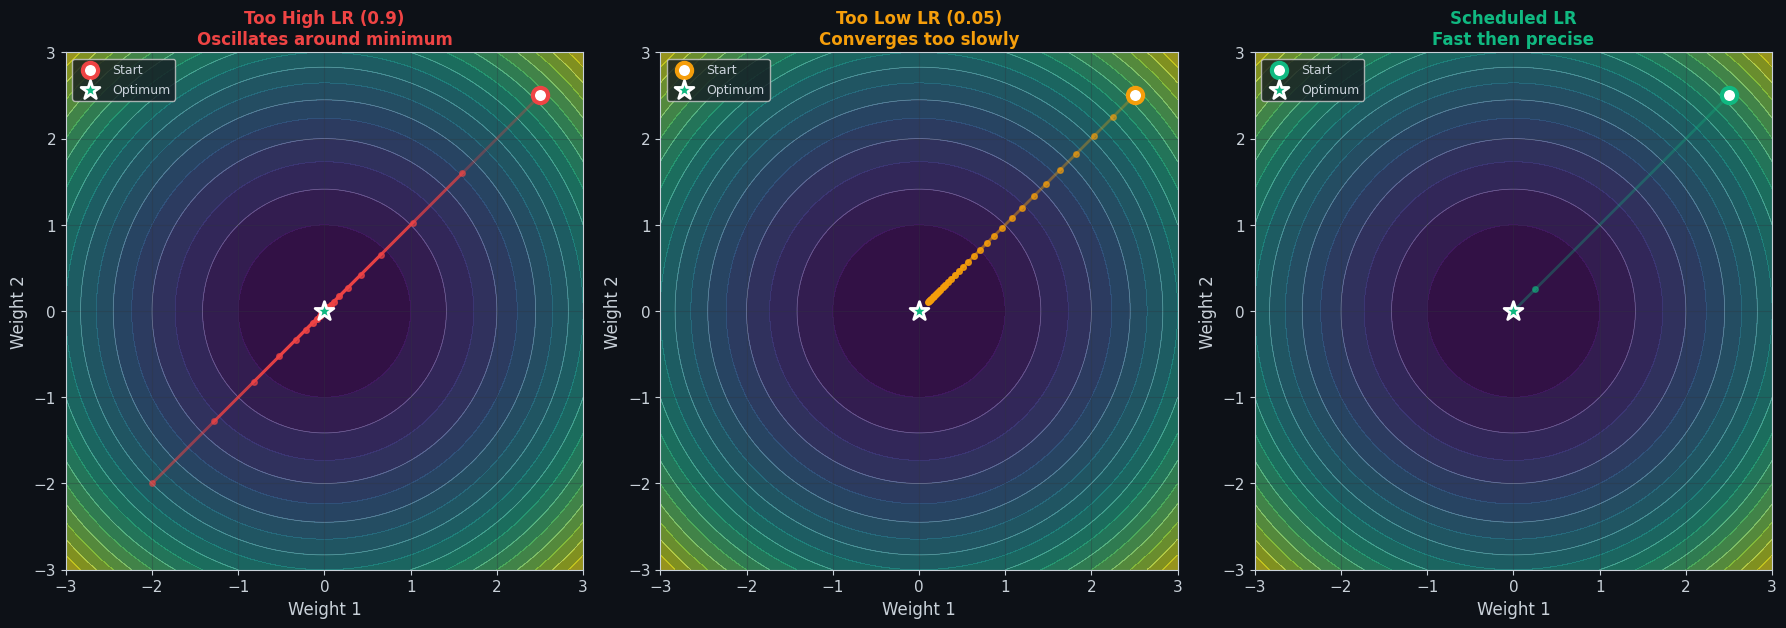


KEY INSIGHT:
   - High LR: Fast initially, but oscillates near optimum
   - Low LR: Stable, but painfully slow
   - Scheduled LR: Best of both worlds!


In [ ]:
# Visualization: Why LR Scheduling Matters - Optimization Trajectory

def visualize_lr_importance():
    """Show how different learning rates affect optimization trajectory."""
    fig = plt.figure(figsize=(18, 6))
    fig.patch.set_facecolor('#0d1117')

    # Create loss surface (2D bowl)
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    Z = X**2 + Y**2

    scenarios = [
        ('Too High LR (0.9)', 0.9, COLORS['too_high'], 'Oscillates around minimum'),
        ('Too Low LR (0.05)', 0.05, COLORS['too_low'], 'Converges too slowly'),
        ('Scheduled LR', 'scheduled', COLORS['optimal'], 'Fast then precise'),
    ]

    for idx, (title, lr, color, note) in enumerate(scenarios):
        ax = fig.add_subplot(1, 3, idx + 1)

        # Plot contours
        contour = ax.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.6)
        ax.contour(X, Y, Z, levels=10, colors='white', alpha=0.3, linewidths=0.5)

        # Simulate gradient descent trajectory
        np.random.seed(42)
        pos = np.array([2.5, 2.5])
        trajectory = [pos.copy()]

        for step in range(30):
            grad = 2 * pos

            if lr == 'scheduled':
                current_lr = 0.5 * (1 + np.cos(np.pi * step / 30)) * 0.4 + 0.05
            else:
                current_lr = lr

            pos = pos - current_lr * grad
            trajectory.append(pos.copy())

        trajectory = np.array(trajectory)

        # Plot trajectory with gradient coloring
        for i in range(len(trajectory) - 1):
            alpha = 0.3 + 0.7 * (i / len(trajectory))
            ax.plot(trajectory[i:i+2, 0], trajectory[i:i+2, 1], 'o-',
                   color=color, markersize=4, linewidth=2, alpha=alpha)

        ax.scatter([2.5], [2.5], c='white', s=120, marker='o',
                  edgecolors=color, linewidth=3, zorder=5, label='Start')
        ax.scatter([0], [0], c=COLORS['optimal'], s=200, marker='*',
                  edgecolors='white', linewidth=2, zorder=5, label='Optimum')

        ax.set_xlabel('Weight 1')
        ax.set_ylabel('Weight 2')
        ax.set_title(f'{title}\n{note}', fontweight='bold', fontsize=12, color=color)
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_aspect('equal')
        ax.legend(loc='upper left', fontsize=9)

    plt.tight_layout()
    plt.show()

visualize_lr_importance()

print("\nKEY INSIGHT:")
print("   - High LR: Fast initially, but oscillates near optimum")
print("   - Low LR: Stable, but painfully slow")
print("   - Scheduled LR: Best of both worlds!")

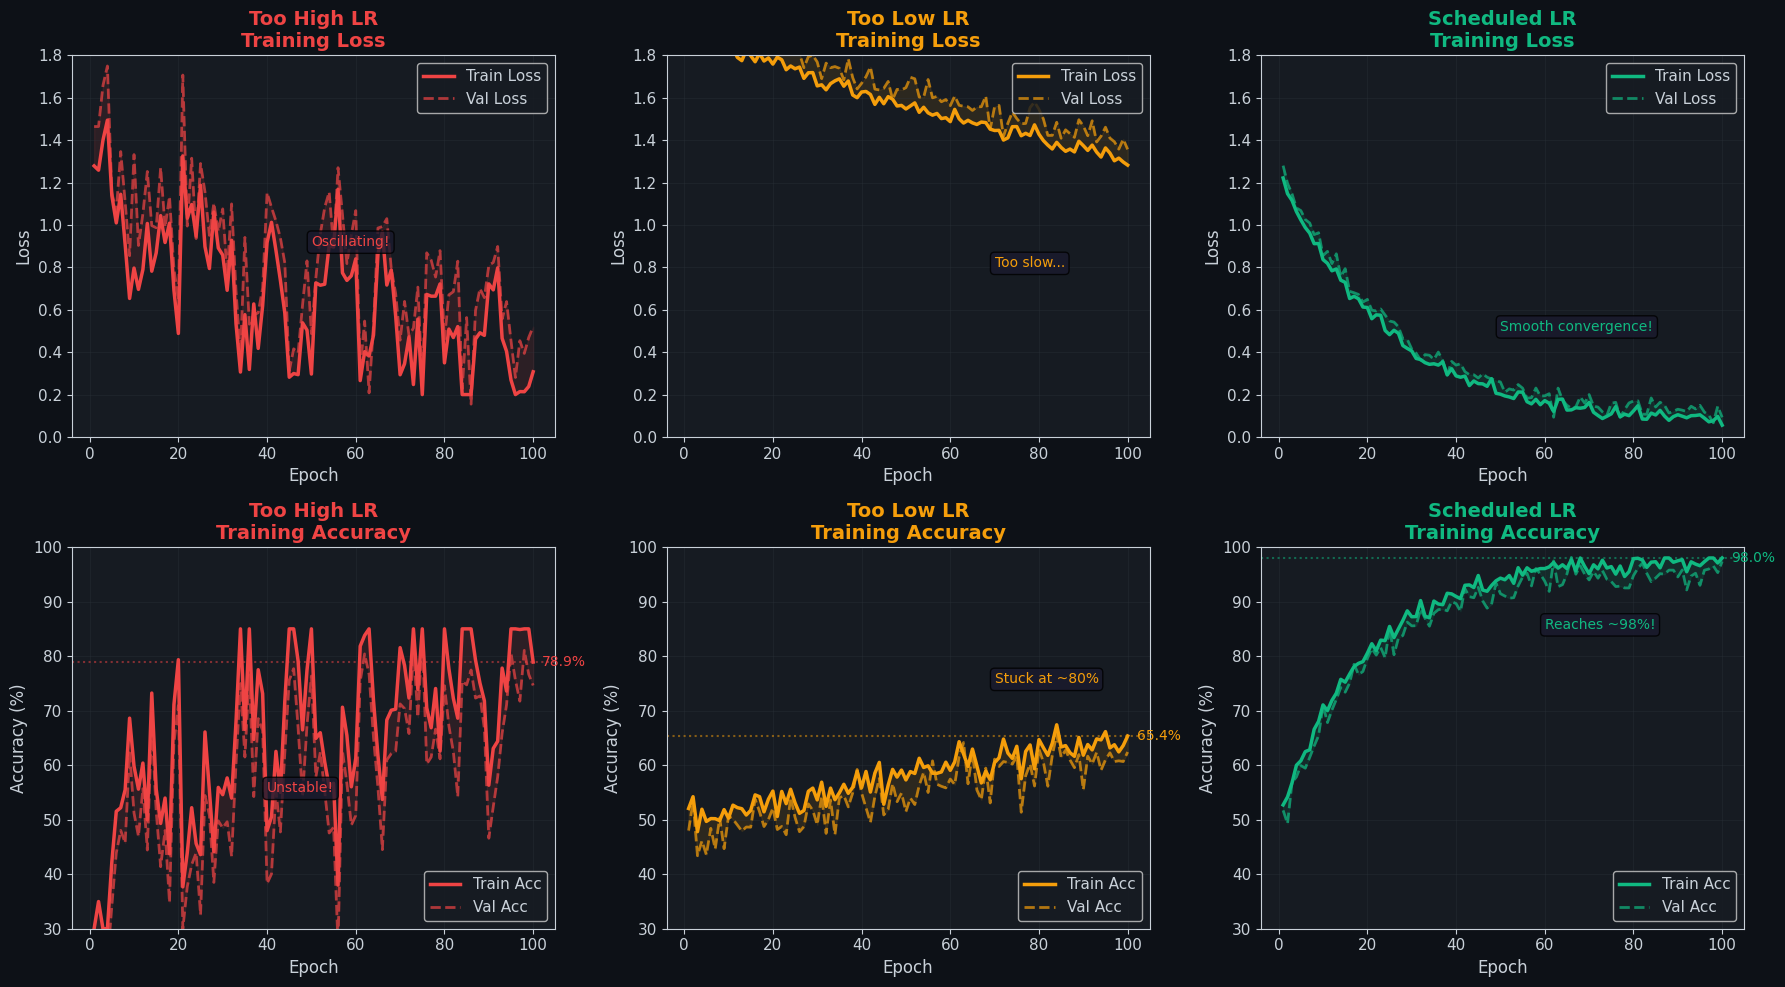


SUMMARY: Effect of Learning Rate on Training

Scenario             Final Train Loss   Final Train Acc    Final Val Acc
----------------------------------------------------------------------
Too High LR          0.3075             78.9              % 74.6%
Too Low LR           1.2821             65.4              % 62.4%
Scheduled LR         0.0556             98.0              % 97.4%


In [ ]:
# NEW: Training Loss and Accuracy Curves for Different LR Scenarios

def visualize_training_metrics_by_lr():
    """Show how different learning rates affect training loss and accuracy over epochs."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.patch.set_facecolor('#0d1117')

    epochs = np.arange(1, 101)
    np.random.seed(42)

    # ========== Too High LR ==========
    # Loss oscillates and may diverge
    noise_high = np.random.randn(100) * 0.15
    loss_high = 0.8 * np.exp(-epochs / 50) + 0.3 + 0.25 * np.sin(epochs / 2) + noise_high
    loss_high = np.clip(loss_high, 0.2, 2.0)
    # Add some spikes (divergence attempts)
    loss_high[20:25] += 0.5
    loss_high[55:60] += 0.4

    # Accuracy is unstable
    acc_high = 100 * (1 - loss_high / 2) + np.random.randn(100) * 5
    acc_high = np.clip(acc_high, 30, 85)

    # Validation metrics (worse due to instability)
    val_loss_high = loss_high + 0.15 + np.random.randn(100) * 0.1
    val_acc_high = acc_high - 8 + np.random.randn(100) * 3

    # ========== Too Low LR ==========
    # Loss decreases very slowly
    noise_low = np.random.randn(100) * 0.02
    loss_low = 1.5 * np.exp(-epochs / 200) + 0.4 + noise_low

    # Accuracy improves slowly
    acc_low = 50 + 30 * (1 - np.exp(-epochs / 150)) + np.random.randn(100) * 2
    acc_low = np.clip(acc_low, 40, 82)

    # Validation metrics
    val_loss_low = loss_low + 0.08 + np.random.randn(100) * 0.03
    val_acc_low = acc_low - 3 + np.random.randn(100) * 2

    # ========== Scheduled (Just Right) LR ==========
    # Smooth convergence to low loss
    noise_opt = np.random.randn(100) * 0.02
    loss_opt = 1.2 * np.exp(-epochs / 25) + 0.05 + noise_opt
    loss_opt = np.clip(loss_opt, 0.03, 1.5)

    # Accuracy reaches high values smoothly
    acc_opt = 50 + 48 * (1 - np.exp(-epochs / 20)) + np.random.randn(100) * 1
    acc_opt = np.clip(acc_opt, 45, 98)

    # Validation metrics (good generalization)
    val_loss_opt = loss_opt + 0.03 + np.random.randn(100) * 0.02
    val_acc_opt = acc_opt - 2 + np.random.randn(100) * 1

    # ========== Plot Training Loss ==========
    scenarios = [
        ('Too High LR', loss_high, val_loss_high, COLORS['too_high']),
        ('Too Low LR', loss_low, val_loss_low, COLORS['too_low']),
        ('Scheduled LR', loss_opt, val_loss_opt, COLORS['optimal']),
    ]

    for idx, (title, train_loss, val_loss, color) in enumerate(scenarios):
        ax = axes[0, idx]
        ax.plot(epochs, train_loss, color=color, linewidth=2.5, label='Train Loss')
        ax.plot(epochs, val_loss, color=color, linewidth=2, linestyle='--',
               alpha=0.7, label='Val Loss')
        ax.fill_between(epochs, train_loss, val_loss, alpha=0.1, color=color)

        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title(f'{title}\nTraining Loss', fontweight='bold', color=color)
        ax.legend(loc='upper right')
        ax.set_ylim(0, 1.8)

    # Add annotations
    axes[0, 0].annotate('Oscillating!', xy=(50, 0.9), fontsize=10, color=COLORS['too_high'],
                       bbox=dict(boxstyle='round', facecolor='#1a1a2e', alpha=0.8))
    axes[0, 1].annotate('Too slow...', xy=(70, 0.8), fontsize=10, color=COLORS['too_low'],
                       bbox=dict(boxstyle='round', facecolor='#1a1a2e', alpha=0.8))
    axes[0, 2].annotate('Smooth convergence!', xy=(50, 0.5), fontsize=10, color=COLORS['optimal'],
                       bbox=dict(boxstyle='round', facecolor='#1a1a2e', alpha=0.8))

    # ========== Plot Training Accuracy ==========
    accuracies = [
        ('Too High LR', acc_high, val_acc_high, COLORS['too_high']),
        ('Too Low LR', acc_low, val_acc_low, COLORS['too_low']),
        ('Scheduled LR', acc_opt, val_acc_opt, COLORS['optimal']),
    ]

    for idx, (title, train_acc, val_acc, color) in enumerate(accuracies):
        ax = axes[1, idx]
        ax.plot(epochs, train_acc, color=color, linewidth=2.5, label='Train Acc')
        ax.plot(epochs, val_acc, color=color, linewidth=2, linestyle='--',
               alpha=0.7, label='Val Acc')
        ax.fill_between(epochs, train_acc, val_acc, alpha=0.1, color=color)

        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(f'{title}\nTraining Accuracy', fontweight='bold', color=color)
        ax.legend(loc='lower right')
        ax.set_ylim(30, 100)

        # Mark final accuracy
        final_acc = train_acc[-1]
        ax.axhline(y=final_acc, color=color, linestyle=':', alpha=0.5)
        ax.text(102, final_acc, f'{final_acc:.1f}%', fontsize=10, color=color, va='center')

    # Add annotations
    axes[1, 0].annotate('Unstable!', xy=(40, 55), fontsize=10, color=COLORS['too_high'],
                       bbox=dict(boxstyle='round', facecolor='#1a1a2e', alpha=0.8))
    axes[1, 1].annotate('Stuck at ~80%', xy=(70, 75), fontsize=10, color=COLORS['too_low'],
                       bbox=dict(boxstyle='round', facecolor='#1a1a2e', alpha=0.8))
    axes[1, 2].annotate('Reaches ~98%!', xy=(60, 85), fontsize=10, color=COLORS['optimal'],
                       bbox=dict(boxstyle='round', facecolor='#1a1a2e', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "="*70)
    print("SUMMARY: Effect of Learning Rate on Training")
    print("="*70)
    print(f"\n{'Scenario':<20} {'Final Train Loss':<18} {'Final Train Acc':<18} {'Final Val Acc'}")
    print("-"*70)
    print(f"{'Too High LR':<20} {loss_high[-1]:<18.4f} {acc_high[-1]:<18.1f}% {val_acc_high[-1]:.1f}%")
    print(f"{'Too Low LR':<20} {loss_low[-1]:<18.4f} {acc_low[-1]:<18.1f}% {val_acc_low[-1]:.1f}%")
    print(f"{'Scheduled LR':<20} {loss_opt[-1]:<18.4f} {acc_opt[-1]:<18.1f}% {val_acc_opt[-1]:.1f}%")

visualize_training_metrics_by_lr()

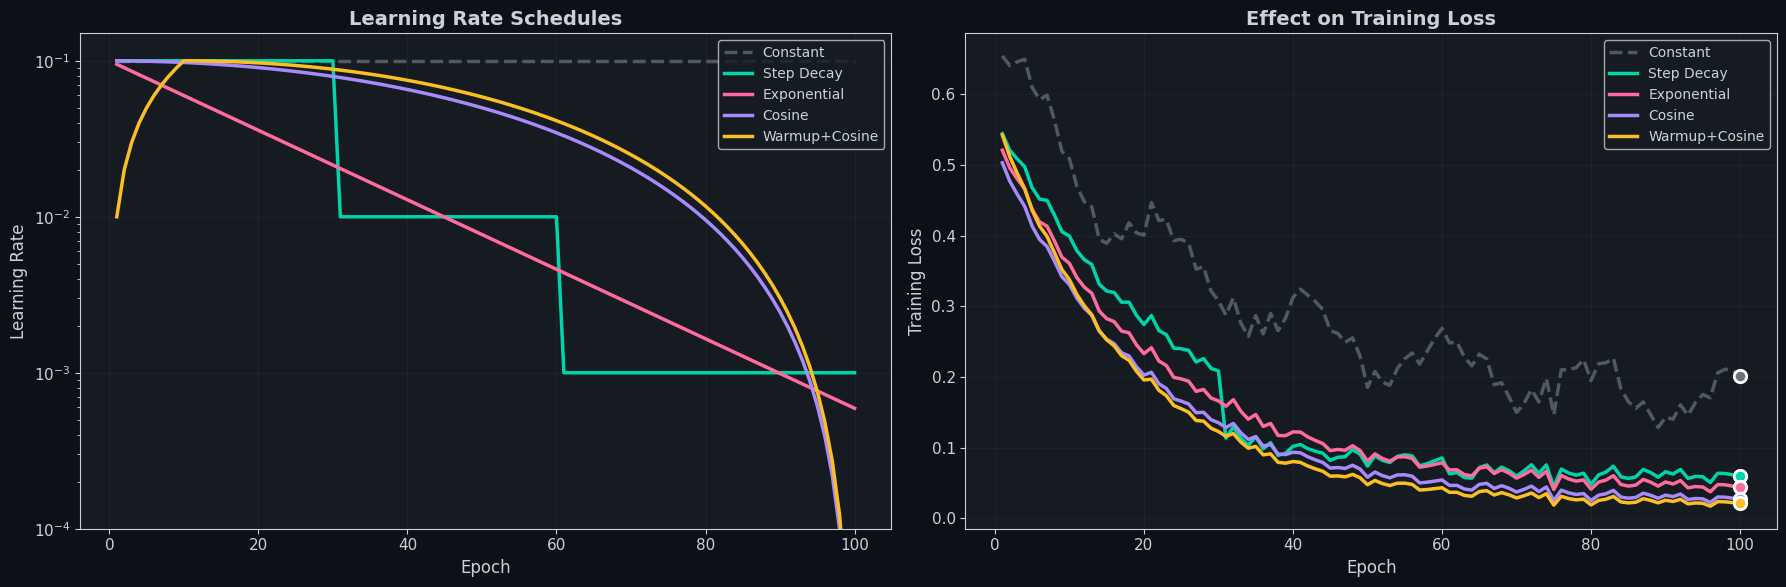


OBSERVATION:
   - Constant LR: Oscillates, cannot fine-tune
   - Step Decay: Good convergence with sudden drops
   - Exponential: Smooth decay, good convergence
   - Cosine: Smooth, often best final performance
   - Warmup+Cosine: Stable start, excellent convergence


In [ ]:
# Visualization: Learning Rate Schedules Overview

def visualize_lr_schedules_overview():
    """Show all major LR schedules in one plot."""
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.patch.set_facecolor('#0d1117')

    epochs = np.arange(1, 101)
    np.random.seed(42)

    # Learning Rate Schedules
    lr_constant = np.ones(100) * 0.1
    lr_step = np.where(epochs <= 30, 0.1, np.where(epochs <= 60, 0.01, 0.001))
    lr_exp = 0.1 * (0.95 ** epochs)
    lr_cosine = 0.1 * 0.5 * (1 + np.cos(np.pi * epochs / 100))
    lr_warmup_cosine = np.where(epochs <= 10, 0.1 * epochs / 10,
                                 0.1 * 0.5 * (1 + np.cos(np.pi * (epochs - 10) / 90)))

    ax1 = axes[0]
    ax1.plot(epochs, lr_constant, color=COLORS['constant'], linewidth=2.5,
            label='Constant', linestyle='--', alpha=0.7)
    ax1.plot(epochs, lr_step, color=COLORS['step'], linewidth=2.5, label='Step Decay')
    ax1.plot(epochs, lr_exp, color=COLORS['exponential'], linewidth=2.5, label='Exponential')
    ax1.plot(epochs, lr_cosine, color=COLORS['cosine'], linewidth=2.5, label='Cosine')
    ax1.plot(epochs, lr_warmup_cosine, color=COLORS['warmup'], linewidth=2.5, label='Warmup+Cosine')

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Learning Rate')
    ax1.set_title('Learning Rate Schedules', fontweight='bold', fontsize=14)
    ax1.legend(loc='upper right', fontsize=10)
    ax1.set_yscale('log')
    ax1.set_ylim(1e-4, 0.15)

    # Simulated Training Loss for each schedule
    noise = np.random.randn(100) * 0.015

    loss_constant = 0.5 * np.exp(-epochs / 30) + 0.15 + 0.04 * np.sin(epochs / 3) + noise
    loss_step = 0.5 * np.exp(-epochs / 25) * np.where(epochs <= 30, 1,
                np.where(epochs <= 60, 0.4, 0.15)) + 0.06 + noise * 0.5
    loss_exp = 0.5 * np.exp(-epochs / 22) + 0.04 + noise * 0.4
    loss_cosine = 0.5 * np.exp(-epochs / 20) + 0.025 + noise * 0.3
    loss_warmup = 0.55 * np.exp(-epochs / 18) + 0.02 + noise * 0.25

    ax2 = axes[1]
    ax2.plot(epochs, loss_constant, color=COLORS['constant'], linewidth=2.5,
            label='Constant', linestyle='--', alpha=0.7)
    ax2.plot(epochs, loss_step, color=COLORS['step'], linewidth=2.5, label='Step Decay')
    ax2.plot(epochs, loss_exp, color=COLORS['exponential'], linewidth=2.5, label='Exponential')
    ax2.plot(epochs, loss_cosine, color=COLORS['cosine'], linewidth=2.5, label='Cosine')
    ax2.plot(epochs, loss_warmup, color=COLORS['warmup'], linewidth=2.5, label='Warmup+Cosine')

    # Mark final losses
    final_losses = [
        (100, loss_constant[-1], COLORS['constant'], 'Constant'),
        (100, loss_step[-1], COLORS['step'], 'Step'),
        (100, loss_exp[-1], COLORS['exponential'], 'Exp'),
        (100, loss_cosine[-1], COLORS['cosine'], 'Cosine'),
        (100, loss_warmup[-1], COLORS['warmup'], 'Warmup'),
    ]
    for x, y, c, name in final_losses:
        ax2.scatter([x], [y], color=c, s=80, zorder=5, edgecolors='white', linewidth=2)

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Training Loss')
    ax2.set_title('Effect on Training Loss', fontweight='bold', fontsize=14)
    ax2.legend(loc='upper right', fontsize=10)

    plt.tight_layout()
    plt.show()

visualize_lr_schedules_overview()

print("\nOBSERVATION:")
print("   - Constant LR: Oscillates, cannot fine-tune")
print("   - Step Decay: Good convergence with sudden drops")
print("   - Exponential: Smooth decay, good convergence")
print("   - Cosine: Smooth, often best final performance")
print("   - Warmup+Cosine: Stable start, excellent convergence")

---

## Part 2: Step Decay

### The Idea

Reduce learning rate by a **fixed factor** at **predetermined epochs**:

$$\eta_t = \eta_0 \cdot \gamma^{\lfloor t / s \rfloor}$$

Where:
- $\eta_0$ = initial learning rate
- $\gamma$ = decay factor (e.g., 0.1)
- $s$ = step size (epochs between drops)
- $\lfloor \cdot \rfloor$ = floor function

### Common Patterns

| Pattern | Description | Example |
|---------|-------------|----------|
| **Fixed Step** | Drop every N epochs | Every 30 epochs |
| **Milestone** | Drop at specific epochs | Epochs 30, 60, 90 |
| **Plateau** | Drop when loss plateaus | If no improvement for 10 epochs |

### When to Use

- Classic image classification (ResNet, VGG)
- When you know roughly how long training takes
- Simple to implement and tune

In [ ]:
# Implementation: Step Decay Schedulers

class StepLR:
    """Step Learning Rate Scheduler."""

    def __init__(self, initial_lr, step_size, gamma=0.1):
        self.initial_lr = initial_lr
        self.step_size = step_size
        self.gamma = gamma

    def get_lr(self, epoch):
        return self.initial_lr * (self.gamma ** (epoch // self.step_size))

    def get_schedule(self, total_epochs):
        return np.array([self.get_lr(e) for e in range(total_epochs)])


class MultiStepLR:
    """Multi-Step Learning Rate Scheduler."""

    def __init__(self, initial_lr, milestones, gamma=0.1):
        self.initial_lr = initial_lr
        self.milestones = sorted(milestones)
        self.gamma = gamma

    def get_lr(self, epoch):
        lr = self.initial_lr
        for milestone in self.milestones:
            if epoch >= milestone:
                lr *= self.gamma
        return lr

    def get_schedule(self, total_epochs):
        return np.array([self.get_lr(e) for e in range(total_epochs)])


class ReduceLROnPlateau:
    """Reduce LR when metric stops improving."""

    def __init__(self, initial_lr, patience=10, factor=0.1, min_lr=1e-7, mode='min'):
        self.lr = initial_lr
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.mode = mode
        self.best = float('inf') if mode == 'min' else float('-inf')
        self.wait = 0
        self.history = []

    def step(self, metric):
        self.history.append(self.lr)

        is_better = (metric < self.best) if self.mode == 'min' else (metric > self.best)

        if is_better:
            self.best = metric
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.lr = max(self.lr * self.factor, self.min_lr)
                self.wait = 0
                return True  # LR was reduced
        return False


# Demonstration
print("STEP DECAY SCHEDULERS")
print("="*50)

# StepLR
step_lr = StepLR(0.1, step_size=30, gamma=0.1)
print("\nStepLR (step_size=30, gamma=0.1):")
for epoch in [0, 29, 30, 59, 60, 89, 90]:
    print(f"  Epoch {epoch:3d}: LR = {step_lr.get_lr(epoch):.6f}")

# MultiStepLR
multi_step = MultiStepLR(0.1, milestones=[30, 60, 90], gamma=0.1)
print("\nMultiStepLR (milestones=[30, 60, 90]):")
for epoch in [0, 30, 60, 90]:
    print(f"  Epoch {epoch:3d}: LR = {multi_step.get_lr(epoch):.6f}")

STEP DECAY SCHEDULERS

StepLR (step_size=30, gamma=0.1):
  Epoch   0: LR = 0.100000
  Epoch  29: LR = 0.100000
  Epoch  30: LR = 0.010000
  Epoch  59: LR = 0.010000
  Epoch  60: LR = 0.001000
  Epoch  89: LR = 0.001000
  Epoch  90: LR = 0.000100

MultiStepLR (milestones=[30, 60, 90]):
  Epoch   0: LR = 0.100000
  Epoch  30: LR = 0.010000
  Epoch  60: LR = 0.001000
  Epoch  90: LR = 0.000100


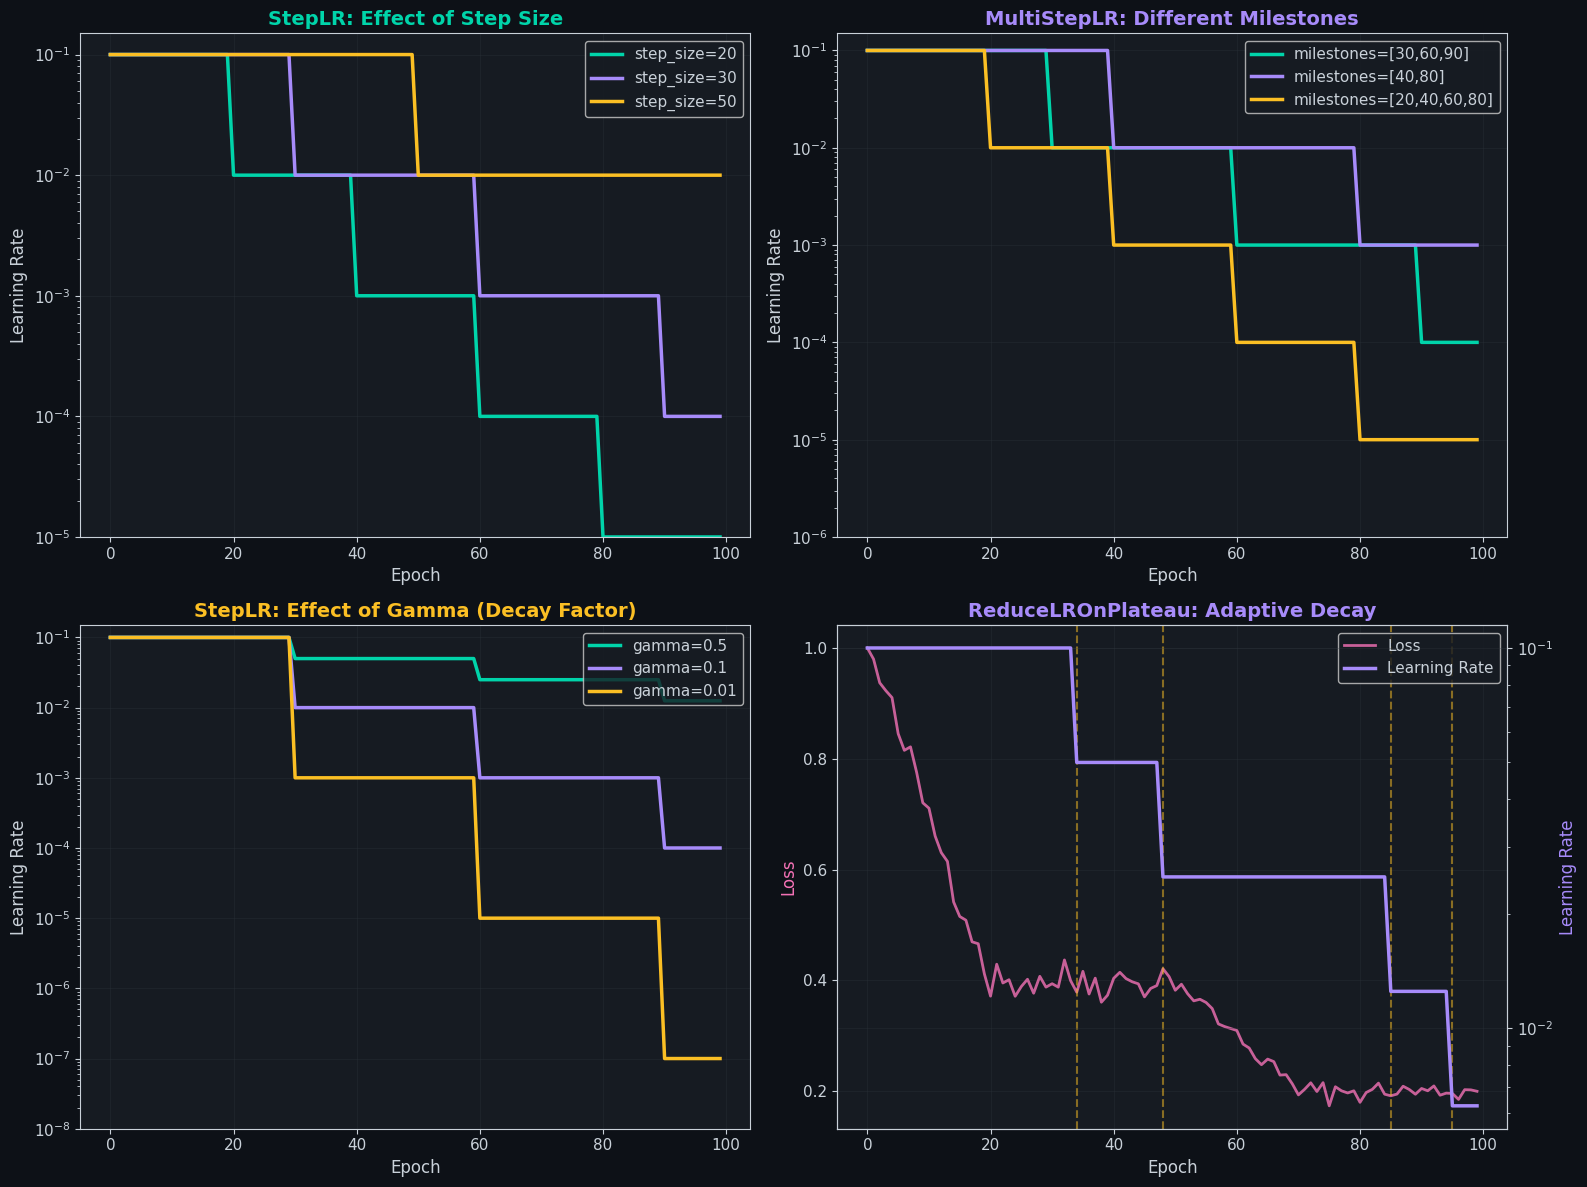


STEP DECAY KEY POINTS:
   - Simple and effective
   - Common pattern: drop by 10x at epochs 30, 60, 90
   - ReduceLROnPlateau: adaptive, data-driven approach


In [ ]:
# Visualization: Step Decay Variants

def visualize_step_decay():
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.patch.set_facecolor('#0d1117')

    epochs = np.arange(100)

    # Plot 1: StepLR with different step sizes
    ax1 = axes[0, 0]
    step_sizes = [20, 30, 50]
    colors = [COLORS['step'], COLORS['cosine'], COLORS['warmup']]

    for step_size, color in zip(step_sizes, colors):
        scheduler = StepLR(0.1, step_size=step_size, gamma=0.1)
        lrs = scheduler.get_schedule(100)
        ax1.plot(epochs, lrs, color=color, linewidth=2.5, label=f'step_size={step_size}')

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Learning Rate')
    ax1.set_title('StepLR: Effect of Step Size', fontweight='bold', color=COLORS['step'])
    ax1.legend(loc='upper right')
    ax1.set_yscale('log')
    ax1.set_ylim(1e-5, 0.15)

    # Plot 2: MultiStepLR with different milestones
    ax2 = axes[0, 1]

    milestone_sets = [
        [30, 60, 90],
        [40, 80],
        [20, 40, 60, 80],
    ]
    labels = ['[30,60,90]', '[40,80]', '[20,40,60,80]']

    for milestones, label, color in zip(milestone_sets, labels, colors):
        scheduler = MultiStepLR(0.1, milestones, gamma=0.1)
        lrs = scheduler.get_schedule(100)
        ax2.plot(epochs, lrs, color=color, linewidth=2.5, label=f'milestones={label}')

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate')
    ax2.set_title('MultiStepLR: Different Milestones', fontweight='bold', color=COLORS['cosine'])
    ax2.legend(loc='upper right')
    ax2.set_yscale('log')
    ax2.set_ylim(1e-6, 0.15)

    # Plot 3: Effect of gamma
    ax3 = axes[1, 0]
    gammas = [0.5, 0.1, 0.01]

    for gamma, color in zip(gammas, colors):
        scheduler = StepLR(0.1, step_size=30, gamma=gamma)
        lrs = scheduler.get_schedule(100)
        ax3.plot(epochs, lrs, color=color, linewidth=2.5, label=f'gamma={gamma}')

    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('StepLR: Effect of Gamma (Decay Factor)', fontweight='bold', color=COLORS['warmup'])
    ax3.legend(loc='upper right')
    ax3.set_yscale('log')
    ax3.set_ylim(1e-8, 0.15)

    # Plot 4: ReduceLROnPlateau simulation
    ax4 = axes[1, 1]

    np.random.seed(42)
    scheduler = ReduceLROnPlateau(initial_lr=0.1, patience=10, factor=0.5)
    lrs = [scheduler.lr]
    losses = [1.0]
    reductions = []

    for epoch in range(1, 100):
        if epoch < 20:
            loss = 1.0 - 0.03 * epoch + np.random.randn() * 0.02
        elif epoch < 50:
            loss = 0.4 + np.random.randn() * 0.02
        elif epoch < 70:
            loss = 0.4 - 0.01 * (epoch - 50) + np.random.randn() * 0.01
        else:
            loss = 0.2 + np.random.randn() * 0.01

        losses.append(max(0.05, loss))
        if scheduler.step(losses[-1]):
            reductions.append(epoch)
        lrs.append(scheduler.lr)

    ax4_twin = ax4.twinx()
    ax4.plot(range(100), losses, color=COLORS['loss'], linewidth=2, label='Loss', alpha=0.8)
    ax4_twin.plot(range(100), lrs, color=COLORS['lr'], linewidth=2.5, label='Learning Rate')

    for r in reductions:
        ax4.axvline(x=r, color=COLORS['highlight'], linestyle='--', alpha=0.5)

    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss', color=COLORS['loss'])
    ax4_twin.set_ylabel('Learning Rate', color=COLORS['lr'])
    ax4_twin.set_yscale('log')
    ax4.set_title('ReduceLROnPlateau: Adaptive Decay', fontweight='bold', color=COLORS['lr'])

    lines1, labels1 = ax4.get_legend_handles_labels()
    lines2, labels2 = ax4_twin.get_legend_handles_labels()
    ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.tight_layout()
    plt.show()

visualize_step_decay()

print("\nSTEP DECAY KEY POINTS:")
print("   - Simple and effective")
print("   - Common pattern: drop by 10x at epochs 30, 60, 90")
print("   - ReduceLROnPlateau: adaptive, data-driven approach")

---

## Part 3: Exponential and Polynomial Decay

### Exponential Decay

$$\eta_t = \eta_0 \cdot \gamma^t$$

Where $\gamma$ is typically 0.95-0.99.

### Inverse Time Decay

$$\eta_t = \frac{\eta_0}{1 + k \cdot t}$$

### Polynomial Decay

$$\eta_t = (\eta_0 - \eta_{end}) \cdot \left(1 - \frac{t}{T}\right)^p + \eta_{end}$$

Where $p$ is the power (1 = linear, 2 = quadratic).

### Properties

| Method | Decay Speed | Smoothness | Use Case |
|--------|-------------|------------|----------|
| Exponential | Fast initially | Very smooth | General training |
| Inverse | Moderate | Smooth | RNN/LSTM |
| Polynomial | Controllable | Smooth | BERT, transformers |

In [ ]:
# Implementation: Exponential and Polynomial Decay

class ExponentialLR:
    """Exponential Learning Rate Scheduler."""

    def __init__(self, initial_lr, gamma=0.95):
        self.initial_lr = initial_lr
        self.gamma = gamma

    def get_lr(self, epoch):
        return self.initial_lr * (self.gamma ** epoch)

    def get_schedule(self, total_epochs):
        return np.array([self.get_lr(e) for e in range(total_epochs)])


class InverseTimeDecay:
    """Inverse Time Decay Scheduler."""

    def __init__(self, initial_lr, decay_rate=0.1):
        self.initial_lr = initial_lr
        self.decay_rate = decay_rate

    def get_lr(self, epoch):
        return self.initial_lr / (1 + self.decay_rate * epoch)

    def get_schedule(self, total_epochs):
        return np.array([self.get_lr(e) for e in range(total_epochs)])


class PolynomialDecay:
    """Polynomial Decay Scheduler."""

    def __init__(self, initial_lr, total_epochs, end_lr=1e-7, power=1.0):
        self.initial_lr = initial_lr
        self.total_epochs = total_epochs
        self.end_lr = end_lr
        self.power = power

    def get_lr(self, epoch):
        if epoch >= self.total_epochs:
            return self.end_lr
        decay = (1 - epoch / self.total_epochs) ** self.power
        return (self.initial_lr - self.end_lr) * decay + self.end_lr

    def get_schedule(self, total_epochs):
        return np.array([self.get_lr(e) for e in range(total_epochs)])


# Demonstration
print("EXPONENTIAL & POLYNOMIAL DECAY")
print("="*50)

print("\nExponential Decay with different gamma:")
for gamma in [0.99, 0.95, 0.9]:
    scheduler = ExponentialLR(0.1, gamma)
    print(f"  gamma={gamma}: Epoch 0={scheduler.get_lr(0):.4f}, "
          f"Epoch 50={scheduler.get_lr(50):.6f}, "
          f"Epoch 100={scheduler.get_lr(100):.8f}")

print("\nPolynomial Decay with different powers:")
for power in [0.5, 1.0, 2.0]:
    scheduler = PolynomialDecay(0.1, 100, 0.001, power)
    print(f"  power={power}: Epoch 50={scheduler.get_lr(50):.6f}")

EXPONENTIAL & POLYNOMIAL DECAY

Exponential Decay with different gamma:
  gamma=0.99: Epoch 0=0.1000, Epoch 50=0.060501, Epoch 100=0.03660323
  gamma=0.95: Epoch 0=0.1000, Epoch 50=0.007694, Epoch 100=0.00059205
  gamma=0.9: Epoch 0=0.1000, Epoch 50=0.000515, Epoch 100=0.00000266

Polynomial Decay with different powers:
  power=0.5: Epoch 50=0.071004
  power=1.0: Epoch 50=0.050500
  power=2.0: Epoch 50=0.025750


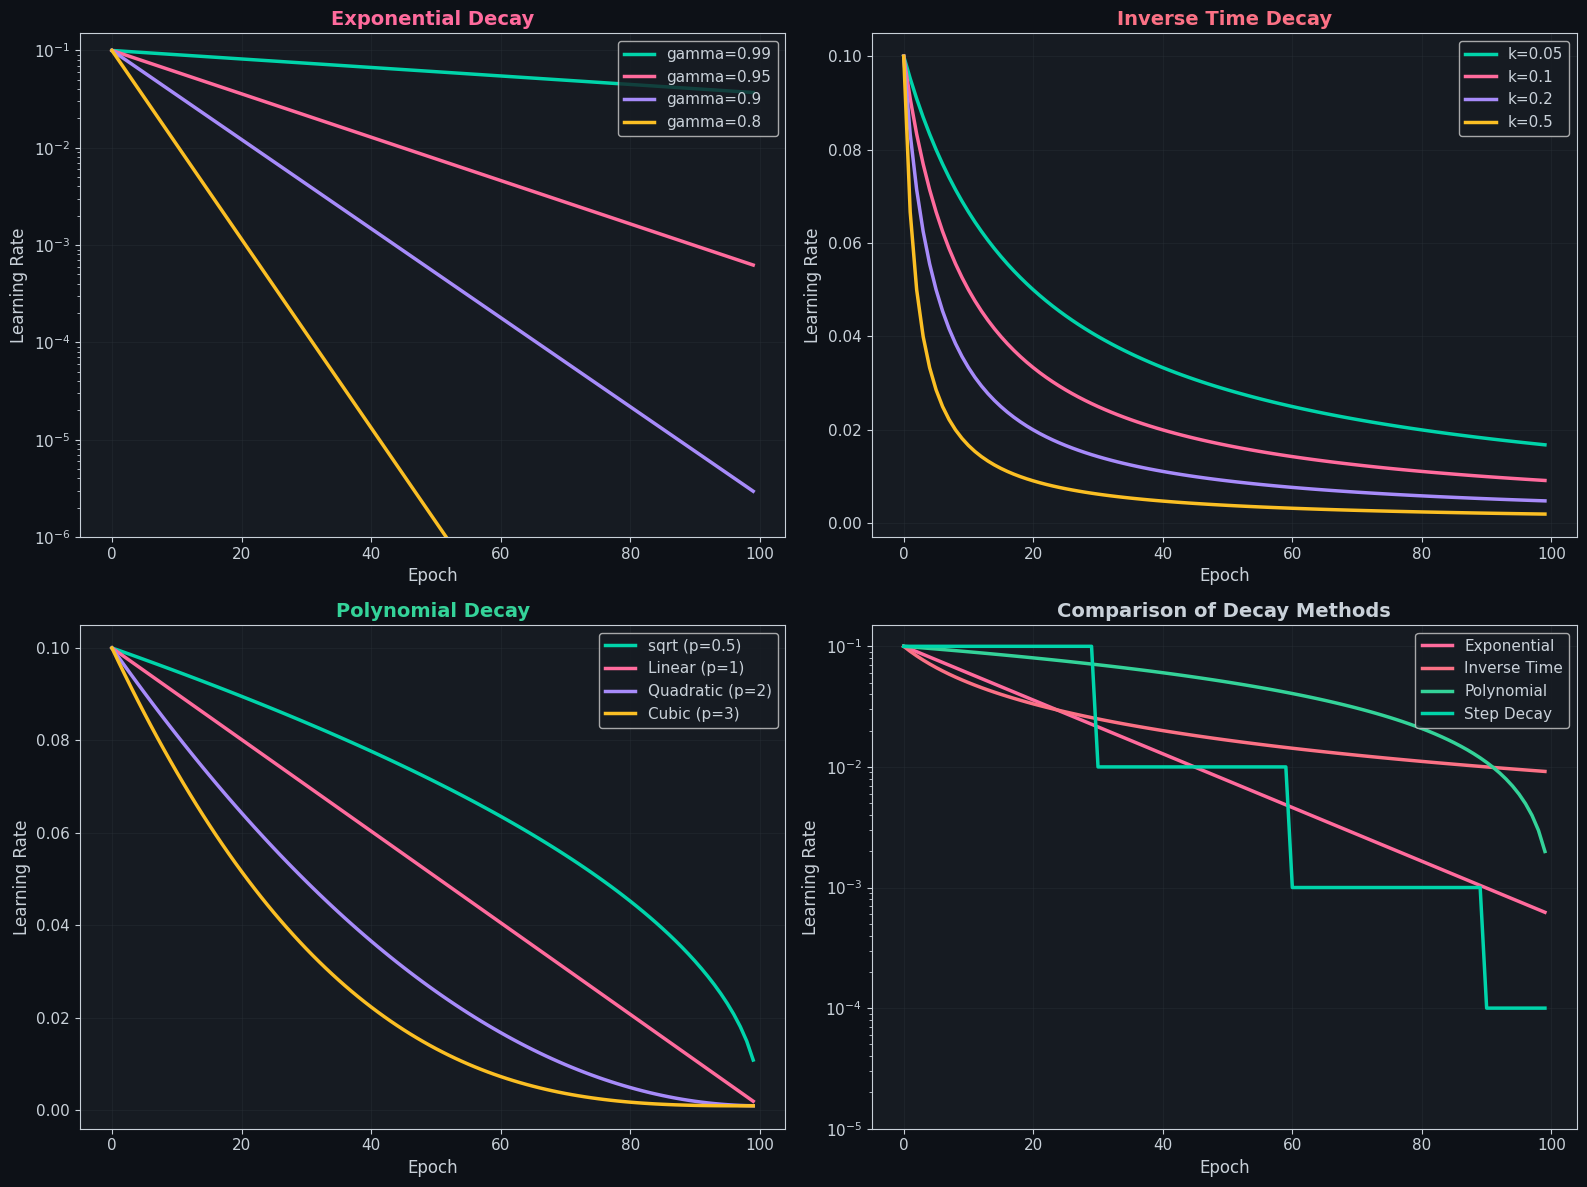

In [ ]:
# Visualization: Exponential and Polynomial Decay

def visualize_decay_methods():
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.patch.set_facecolor('#0d1117')

    epochs = np.arange(100)

    # Plot 1: Exponential with different gamma
    ax1 = axes[0, 0]
    gammas = [0.99, 0.95, 0.9, 0.8]
    colors = [COLORS['step'], COLORS['exponential'], COLORS['cosine'], COLORS['warmup']]

    for gamma, color in zip(gammas, colors):
        scheduler = ExponentialLR(0.1, gamma)
        lrs = scheduler.get_schedule(100)
        ax1.plot(epochs, lrs, color=color, linewidth=2.5, label=f'gamma={gamma}')

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Learning Rate')
    ax1.set_title('Exponential Decay', fontweight='bold', color=COLORS['exponential'])
    ax1.legend(loc='upper right')
    ax1.set_yscale('log')
    ax1.set_ylim(1e-6, 0.15)

    # Plot 2: Inverse Time Decay
    ax2 = axes[0, 1]
    decay_rates = [0.05, 0.1, 0.2, 0.5]

    for rate, color in zip(decay_rates, colors):
        scheduler = InverseTimeDecay(0.1, rate)
        lrs = scheduler.get_schedule(100)
        ax2.plot(epochs, lrs, color=color, linewidth=2.5, label=f'k={rate}')

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate')
    ax2.set_title('Inverse Time Decay', fontweight='bold', color=COLORS['inverse'])
    ax2.legend(loc='upper right')

    # Plot 3: Polynomial Decay
    ax3 = axes[1, 0]
    powers = [0.5, 1.0, 2.0, 3.0]
    labels = ['sqrt (p=0.5)', 'Linear (p=1)', 'Quadratic (p=2)', 'Cubic (p=3)']

    for power, label, color in zip(powers, labels, colors):
        scheduler = PolynomialDecay(0.1, 100, 0.001, power)
        lrs = scheduler.get_schedule(100)
        ax3.plot(epochs, lrs, color=color, linewidth=2.5, label=label)

    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('Polynomial Decay', fontweight='bold', color=COLORS['polynomial'])
    ax3.legend(loc='upper right')

    # Plot 4: All decay types comparison
    ax4 = axes[1, 1]

    exp = ExponentialLR(0.1, 0.95)
    inv = InverseTimeDecay(0.1, 0.1)
    poly = PolynomialDecay(0.1, 100, 0.001, 1.0)
    step = MultiStepLR(0.1, [30, 60, 90], 0.1)

    ax4.plot(epochs, exp.get_schedule(100), color=COLORS['exponential'],
            linewidth=2.5, label='Exponential')
    ax4.plot(epochs, inv.get_schedule(100), color=COLORS['inverse'],
            linewidth=2.5, label='Inverse Time')
    ax4.plot(epochs, poly.get_schedule(100), color=COLORS['polynomial'],
            linewidth=2.5, label='Polynomial')
    ax4.plot(epochs, step.get_schedule(100), color=COLORS['step'],
            linewidth=2.5, label='Step Decay')

    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Learning Rate')
    ax4.set_title('Comparison of Decay Methods', fontweight='bold')
    ax4.legend(loc='upper right')
    ax4.set_yscale('log')
    ax4.set_ylim(1e-5, 0.15)

    plt.tight_layout()
    plt.show()

visualize_decay_methods()

---

## Part 4: Cosine Annealing

### The Formula

$$\eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})\left(1 + \cos\left(\frac{\pi t}{T}\right)\right)$$

### Why Cosine?

1. **Gentle start**: Slow initial decrease (when LR is high)
2. **Fast middle**: Rapid decrease in the middle phase
3. **Gentle end**: Slow approach to minimum (fine-tuning)

### Cosine Annealing with Warm Restarts (SGDR)

Periodically "restart" the learning rate to escape local minima:

$$\eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})\left(1 + \cos\left(\frac{\pi T_{cur}}{T_i}\right)\right)$$

Where $T_i$ can increase after each restart (e.g., $T_i = T_0 \cdot T_{mult}^i$).

In [ ]:
# Implementation: Cosine Annealing

class CosineAnnealingLR:
    """Cosine Annealing Learning Rate Scheduler."""

    def __init__(self, initial_lr, total_epochs, min_lr=0):
        self.initial_lr = initial_lr
        self.total_epochs = total_epochs
        self.min_lr = min_lr

    def get_lr(self, epoch):
        return self.min_lr + 0.5 * (self.initial_lr - self.min_lr) * \
               (1 + np.cos(np.pi * epoch / self.total_epochs))

    def get_schedule(self, total_epochs=None):
        if total_epochs is None:
            total_epochs = self.total_epochs
        return np.array([self.get_lr(e) for e in range(total_epochs)])


class CosineAnnealingWarmRestarts:
    """Cosine Annealing with Warm Restarts (SGDR)."""

    def __init__(self, initial_lr, T_0, T_mult=1, min_lr=0):
        self.initial_lr = initial_lr
        self.T_0 = T_0
        self.T_mult = T_mult
        self.min_lr = min_lr

    def get_lr(self, epoch):
        if self.T_mult == 1:
            T_cur = epoch % self.T_0
            T_i = self.T_0
        else:
            T_i = self.T_0
            T_cur = epoch
            while T_cur >= T_i:
                T_cur -= T_i
                T_i = int(T_i * self.T_mult)

        return self.min_lr + 0.5 * (self.initial_lr - self.min_lr) * \
               (1 + np.cos(np.pi * T_cur / T_i))

    def get_schedule(self, total_epochs):
        return np.array([self.get_lr(e) for e in range(total_epochs)])


# Demonstration
print("COSINE ANNEALING")
print("="*50)

cosine = CosineAnnealingLR(0.1, 100, 0.001)
print("\nCosineAnnealingLR (100 epochs):")
for epoch in [0, 25, 50, 75, 100]:
    print(f"  Epoch {epoch:3d}: LR = {cosine.get_lr(epoch):.6f}")

sgdr = CosineAnnealingWarmRestarts(0.1, T_0=25, T_mult=2, min_lr=0.001)
print("\nSGDR (T_0=25, T_mult=2):")
for epoch in [0, 24, 25, 74, 75]:
    print(f"  Epoch {epoch:3d}: LR = {sgdr.get_lr(epoch):.6f}")

COSINE ANNEALING

CosineAnnealingLR (100 epochs):
  Epoch   0: LR = 0.100000
  Epoch  25: LR = 0.085502
  Epoch  50: LR = 0.050500
  Epoch  75: LR = 0.015498
  Epoch 100: LR = 0.001000

SGDR (T_0=25, T_mult=2):
  Epoch   0: LR = 0.100000
  Epoch  24: LR = 0.001390
  Epoch  25: LR = 0.100000
  Epoch  74: LR = 0.001098
  Epoch  75: LR = 0.100000


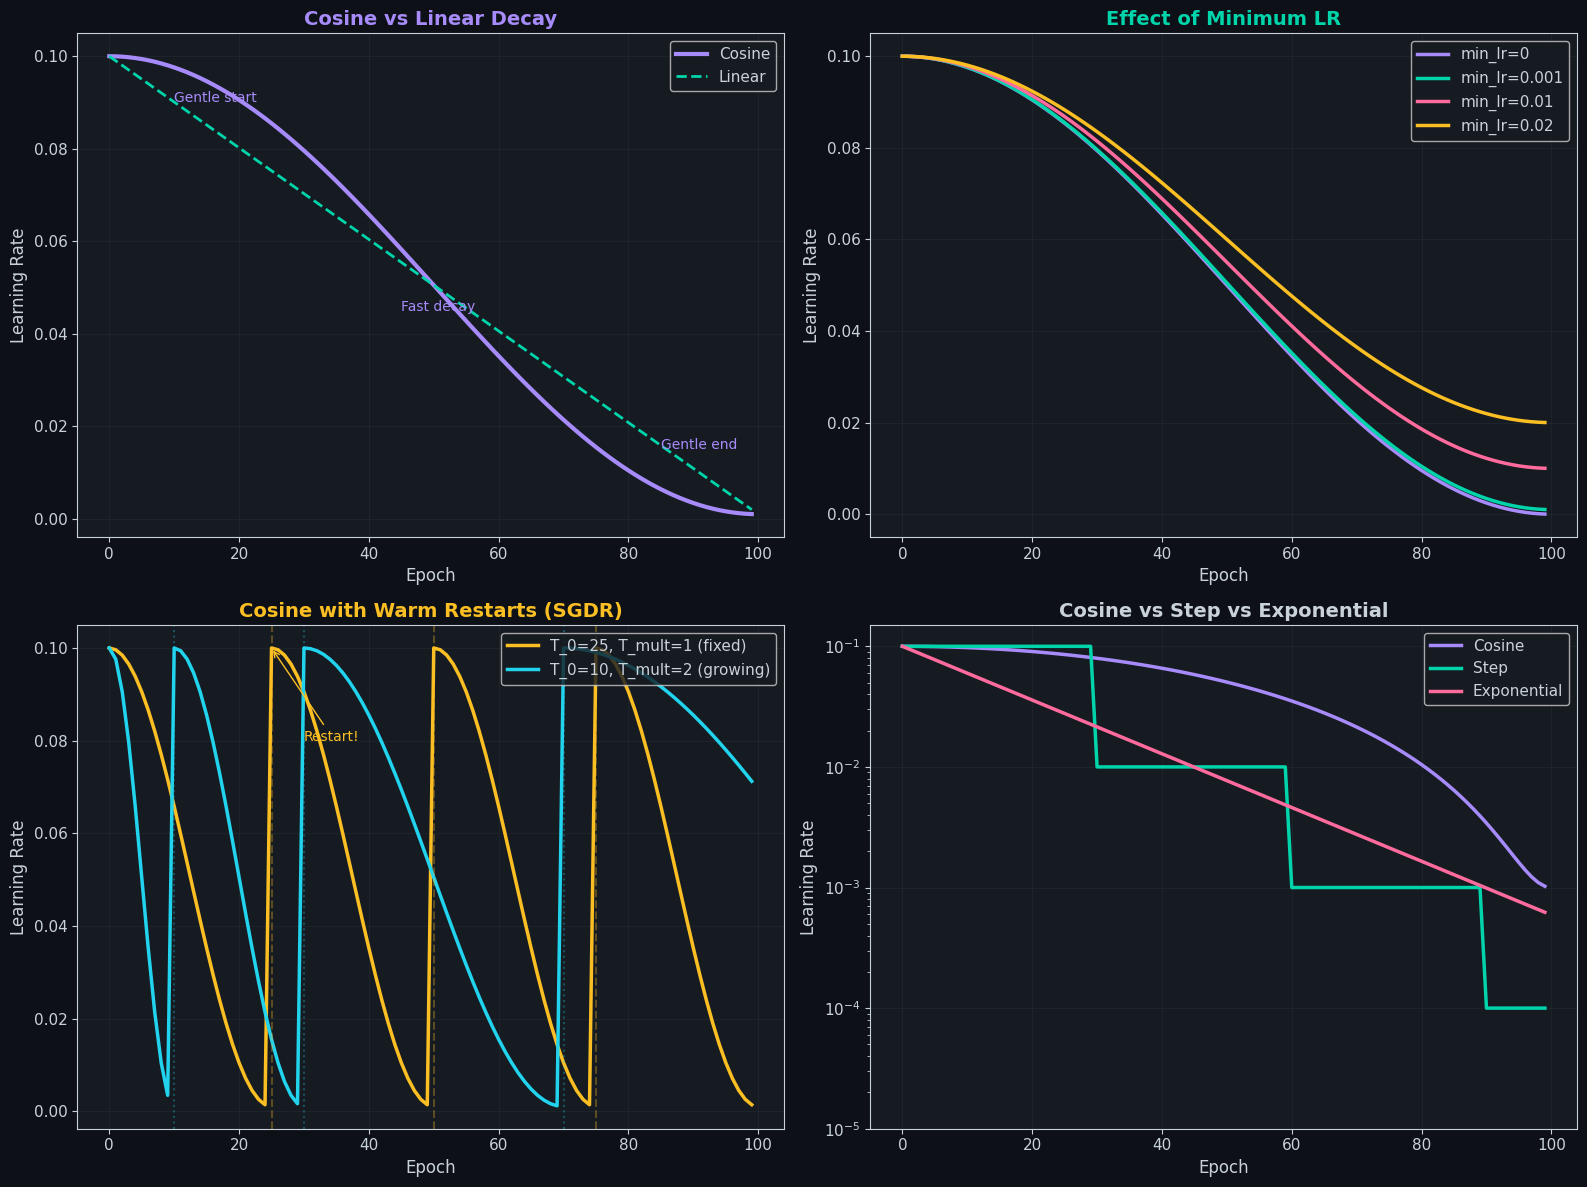


COSINE ANNEALING KEY POINTS:
   - Smooth, natural decay curve
   - Gentle at start and end, faster in middle
   - SGDR: periodic restarts to escape local minima
   - Often achieves best final performance


In [ ]:
# Visualization: Cosine Annealing

def visualize_cosine_annealing():
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.patch.set_facecolor('#0d1117')

    epochs = np.arange(100)

    # Plot 1: Cosine vs Linear
    ax1 = axes[0, 0]

    cosine = CosineAnnealingLR(0.1, 100, 0.001)
    linear = PolynomialDecay(0.1, 100, 0.001, power=1.0)

    ax1.plot(epochs, cosine.get_schedule(), color=COLORS['cosine'],
            linewidth=3, label='Cosine')
    ax1.plot(epochs, linear.get_schedule(100), color=COLORS['step'],
            linewidth=2, linestyle='--', label='Linear')

    # Annotate characteristics
    ax1.annotate('Gentle start', xy=(10, 0.09), fontsize=10, color=COLORS['cosine'])
    ax1.annotate('Fast decay', xy=(45, 0.045), fontsize=10, color=COLORS['cosine'])
    ax1.annotate('Gentle end', xy=(85, 0.015), fontsize=10, color=COLORS['cosine'])

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Learning Rate')
    ax1.set_title('Cosine vs Linear Decay', fontweight='bold', color=COLORS['cosine'])
    ax1.legend(loc='upper right')

    # Plot 2: Different min_lr
    ax2 = axes[0, 1]
    min_lrs = [0, 0.001, 0.01, 0.02]
    colors = [COLORS['cosine'], COLORS['step'], COLORS['exponential'], COLORS['warmup']]

    for min_lr, color in zip(min_lrs, colors):
        scheduler = CosineAnnealingLR(0.1, 100, min_lr)
        ax2.plot(epochs, scheduler.get_schedule(), color=color,
                linewidth=2.5, label=f'min_lr={min_lr}')

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate')
    ax2.set_title('Effect of Minimum LR', fontweight='bold', color=COLORS['step'])
    ax2.legend(loc='upper right')

    # Plot 3: Warm Restarts (SGDR)
    ax3 = axes[1, 0]

    sgdr_fixed = CosineAnnealingWarmRestarts(0.1, T_0=25, T_mult=1, min_lr=0.001)
    sgdr_mult = CosineAnnealingWarmRestarts(0.1, T_0=10, T_mult=2, min_lr=0.001)

    ax3.plot(epochs, sgdr_fixed.get_schedule(100), color=COLORS['warmup'],
            linewidth=2.5, label='T_0=25, T_mult=1 (fixed)')
    ax3.plot(epochs, sgdr_mult.get_schedule(100), color=COLORS['cyclic'],
            linewidth=2.5, label='T_0=10, T_mult=2 (growing)')

    # Mark restarts
    for x in [25, 50, 75]:
        ax3.axvline(x=x, color=COLORS['warmup'], linestyle='--', alpha=0.3)
    for x in [10, 30, 70]:
        ax3.axvline(x=x, color=COLORS['cyclic'], linestyle=':', alpha=0.3)

    ax3.annotate('Restart!', xy=(25, 0.1), xytext=(30, 0.08),
                arrowprops=dict(arrowstyle='->', color=COLORS['warmup']),
                color=COLORS['warmup'], fontsize=10)

    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('Cosine with Warm Restarts (SGDR)', fontweight='bold', color=COLORS['warmup'])
    ax3.legend(loc='upper right')

    # Plot 4: Comparison
    ax4 = axes[1, 1]

    cosine = CosineAnnealingLR(0.1, 100, 0.001)
    step = MultiStepLR(0.1, [30, 60, 90], 0.1)
    exp = ExponentialLR(0.1, 0.95)

    ax4.plot(epochs, cosine.get_schedule(), color=COLORS['cosine'],
            linewidth=2.5, label='Cosine')
    ax4.plot(epochs, step.get_schedule(100), color=COLORS['step'],
            linewidth=2.5, label='Step')
    ax4.plot(epochs, exp.get_schedule(100), color=COLORS['exponential'],
            linewidth=2.5, label='Exponential')

    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Learning Rate')
    ax4.set_title('Cosine vs Step vs Exponential', fontweight='bold')
    ax4.legend(loc='upper right')
    ax4.set_yscale('log')
    ax4.set_ylim(1e-5, 0.15)

    plt.tight_layout()
    plt.show()

visualize_cosine_annealing()

print("\nCOSINE ANNEALING KEY POINTS:")
print("   - Smooth, natural decay curve")
print("   - Gentle at start and end, faster in middle")
print("   - SGDR: periodic restarts to escape local minima")
print("   - Often achieves best final performance")

---

## Part 5: Warmup Strategies

### The Problem

At the start of training:
- Weights are random and gradients are unstable
- Large LR + unstable gradients = exploding updates!

### The Solution: Warmup!

Start with a **small learning rate** and gradually increase to the target LR.

### Types of Warmup

| Type | Formula | Description |
|------|---------|-------------|
| **Linear** | $\eta_t = \frac{t}{T_w} \cdot \eta_{max}$ | Linearly increase |
| **Exponential** | $\eta_t = \eta_{max} \cdot \gamma^{T_w - t}$ | Exponentially increase |
| **Gradual** | $\eta_t = \eta_{max} \cdot (1 - e^{-t/\tau})$ | Smooth approach |

### When to Use Warmup

- Large learning rates (> 0.01)
- Large batch sizes
- Transformers (almost always use warmup)
- When training is unstable at the start

In [ ]:
# Implementation: Warmup Schedulers

class LinearWarmup:
    """Linear Warmup followed by decay."""

    def __init__(self, initial_lr, warmup_epochs, total_epochs,
                 after_scheduler='cosine', min_lr=0):
        self.initial_lr = initial_lr
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.after_scheduler = after_scheduler
        self.min_lr = min_lr

    def get_lr(self, epoch):
        if epoch < self.warmup_epochs:
            return self.initial_lr * (epoch + 1) / self.warmup_epochs
        else:
            adjusted_epoch = epoch - self.warmup_epochs
            remaining_epochs = self.total_epochs - self.warmup_epochs

            if self.after_scheduler == 'cosine':
                return self.min_lr + 0.5 * (self.initial_lr - self.min_lr) * \
                       (1 + np.cos(np.pi * adjusted_epoch / remaining_epochs))
            elif self.after_scheduler == 'linear':
                decay = 1 - adjusted_epoch / remaining_epochs
                return self.min_lr + (self.initial_lr - self.min_lr) * decay
            else:  # constant
                return self.initial_lr

    def get_schedule(self, total_epochs=None):
        if total_epochs is None:
            total_epochs = self.total_epochs
        return np.array([self.get_lr(e) for e in range(total_epochs)])


class OneCycleLR:
    """1Cycle Learning Rate Policy (Smith, 2018)."""

    def __init__(self, max_lr, total_epochs, pct_start=0.3,
                 div_factor=25, final_div_factor=1e4):
        self.max_lr = max_lr
        self.total_epochs = total_epochs
        self.pct_start = pct_start
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor

        self.initial_lr = max_lr / div_factor
        self.final_lr = max_lr / final_div_factor
        self.warmup_epochs = int(total_epochs * pct_start)

    def get_lr(self, epoch):
        if epoch < self.warmup_epochs:
            pct = epoch / self.warmup_epochs
            return self.initial_lr + (self.max_lr - self.initial_lr) * pct
        else:
            pct = (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            return self.final_lr + 0.5 * (self.max_lr - self.final_lr) * \
                   (1 + np.cos(np.pi * pct))

    def get_schedule(self, total_epochs=None):
        if total_epochs is None:
            total_epochs = self.total_epochs
        return np.array([self.get_lr(e) for e in range(total_epochs)])


class CyclicLR:
    """Cyclic Learning Rate (Smith, 2017)."""

    def __init__(self, base_lr, max_lr, step_size, mode='triangular', gamma=1.0):
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma

    def get_lr(self, epoch):
        cycle = np.floor(1 + epoch / (2 * self.step_size))
        x = np.abs(epoch / self.step_size - 2 * cycle + 1)

        if self.mode == 'triangular':
            return self.base_lr + (self.max_lr - self.base_lr) * max(0, 1 - x)
        elif self.mode == 'triangular2':
            return self.base_lr + (self.max_lr - self.base_lr) * max(0, 1 - x) / (2 ** (cycle - 1))
        else:  # exp_range
            return self.base_lr + (self.max_lr - self.base_lr) * max(0, 1 - x) * (self.gamma ** epoch)

    def get_schedule(self, total_epochs):
        return np.array([self.get_lr(e) for e in range(total_epochs)])


# Demonstration
print("WARMUP AND CYCLIC SCHEDULERS")
print("="*50)

warmup = LinearWarmup(0.1, warmup_epochs=10, total_epochs=100,
                      after_scheduler='cosine', min_lr=0.001)
print("\nLinear Warmup + Cosine:")
for epoch in [0, 5, 10, 50, 99]:
    print(f"  Epoch {epoch:3d}: LR = {warmup.get_lr(epoch):.6f}")

one_cycle = OneCycleLR(max_lr=0.1, total_epochs=100)
print("\n1Cycle Policy:")
for epoch in [0, 15, 30, 65, 99]:
    print(f"  Epoch {epoch:3d}: LR = {one_cycle.get_lr(epoch):.6f}")

WARMUP AND CYCLIC SCHEDULERS

Linear Warmup + Cosine:
  Epoch   0: LR = 0.010000
  Epoch   5: LR = 0.060000
  Epoch  10: LR = 0.100000
  Epoch  50: LR = 0.059096
  Epoch  99: LR = 0.001030

1Cycle Policy:
  Epoch   0: LR = 0.004000
  Epoch  15: LR = 0.052000
  Epoch  30: LR = 0.100000
  Epoch  65: LR = 0.050005
  Epoch  99: LR = 0.000060


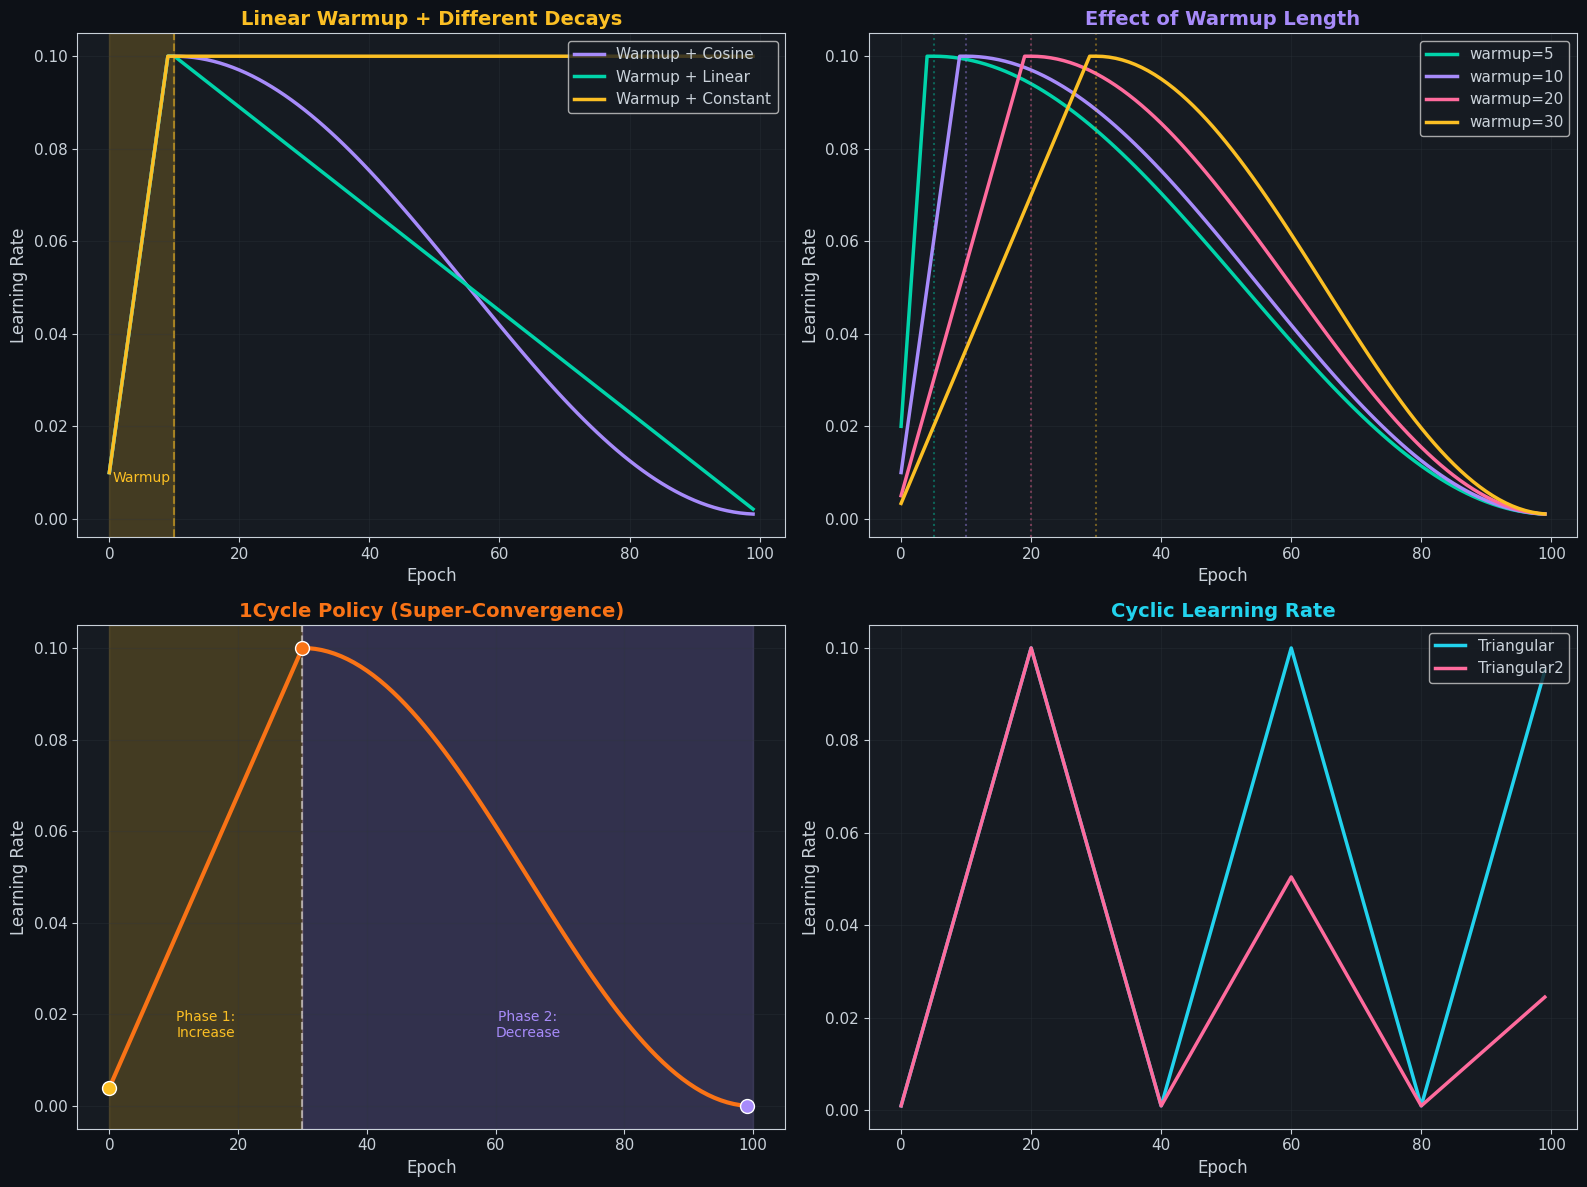


WARMUP KEY POINTS:
   - Stabilizes early training with large LR
   - 5-10% of training is common for warmup
   - 1Cycle: increase then decrease (super-convergence)
   - Cyclic: oscillate between bounds (exploration)


In [ ]:
# Visualization: Warmup Strategies

def visualize_warmup():
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.patch.set_facecolor('#0d1117')

    epochs = np.arange(100)

    # Plot 1: Warmup + Different Decays
    ax1 = axes[0, 0]

    warmup_cosine = LinearWarmup(0.1, 10, 100, 'cosine', 0.001)
    warmup_linear = LinearWarmup(0.1, 10, 100, 'linear', 0.001)
    warmup_constant = LinearWarmup(0.1, 10, 100, 'constant', 0.001)

    ax1.plot(epochs, warmup_cosine.get_schedule(), color=COLORS['cosine'],
            linewidth=2.5, label='Warmup + Cosine')
    ax1.plot(epochs, warmup_linear.get_schedule(), color=COLORS['step'],
            linewidth=2.5, label='Warmup + Linear')
    ax1.plot(epochs, warmup_constant.get_schedule(), color=COLORS['warmup'],
            linewidth=2.5, label='Warmup + Constant')

    ax1.axvspan(0, 10, alpha=0.2, color=COLORS['warmup'])
    ax1.axvline(x=10, color=COLORS['warmup'], linestyle='--', alpha=0.5)
    ax1.text(5, 0.008, 'Warmup', ha='center', fontsize=10, color=COLORS['warmup'])

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Learning Rate')
    ax1.set_title('Linear Warmup + Different Decays', fontweight='bold', color=COLORS['warmup'])
    ax1.legend(loc='upper right')

    # Plot 2: Different Warmup Lengths
    ax2 = axes[0, 1]
    warmup_lengths = [5, 10, 20, 30]
    colors = [COLORS['step'], COLORS['cosine'], COLORS['exponential'], COLORS['warmup']]

    for length, color in zip(warmup_lengths, colors):
        scheduler = LinearWarmup(0.1, length, 100, 'cosine', 0.001)
        ax2.plot(epochs, scheduler.get_schedule(), color=color,
                linewidth=2.5, label=f'warmup={length}')
        ax2.axvline(x=length, color=color, linestyle=':', alpha=0.4)

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate')
    ax2.set_title('Effect of Warmup Length', fontweight='bold', color=COLORS['cosine'])
    ax2.legend(loc='upper right')

    # Plot 3: 1Cycle Policy
    ax3 = axes[1, 0]

    one_cycle = OneCycleLR(0.1, 100, pct_start=0.3)
    lrs = one_cycle.get_schedule()

    ax3.plot(epochs, lrs, color=COLORS['onecycle'], linewidth=3)

    warmup_end = int(100 * 0.3)
    ax3.axvspan(0, warmup_end, alpha=0.2, color=COLORS['warmup'])
    ax3.axvspan(warmup_end, 100, alpha=0.2, color=COLORS['cosine'])
    ax3.axvline(x=warmup_end, color='white', linestyle='--', alpha=0.5)

    ax3.scatter([0], [lrs[0]], color=COLORS['warmup'], s=100, zorder=5, edgecolors='white')
    ax3.scatter([warmup_end], [lrs[warmup_end]], color=COLORS['onecycle'], s=100, zorder=5, edgecolors='white')
    ax3.scatter([99], [lrs[99]], color=COLORS['cosine'], s=100, zorder=5, edgecolors='white')

    ax3.text(15, 0.015, 'Phase 1:\nIncrease', ha='center', fontsize=10, color=COLORS['warmup'])
    ax3.text(65, 0.015, 'Phase 2:\nDecrease', ha='center', fontsize=10, color=COLORS['cosine'])

    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('1Cycle Policy (Super-Convergence)', fontweight='bold', color=COLORS['onecycle'])

    # Plot 4: Cyclic LR
    ax4 = axes[1, 1]

    cyclic_tri = CyclicLR(0.001, 0.1, step_size=20, mode='triangular')
    cyclic_tri2 = CyclicLR(0.001, 0.1, step_size=20, mode='triangular2')

    ax4.plot(epochs, cyclic_tri.get_schedule(100), color=COLORS['cyclic'],
            linewidth=2.5, label='Triangular')
    ax4.plot(epochs, cyclic_tri2.get_schedule(100), color=COLORS['exponential'],
            linewidth=2.5, label='Triangular2')

    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Learning Rate')
    ax4.set_title('Cyclic Learning Rate', fontweight='bold', color=COLORS['cyclic'])
    ax4.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

visualize_warmup()

print("\nWARMUP KEY POINTS:")
print("   - Stabilizes early training with large LR")
print("   - 5-10% of training is common for warmup")
print("   - 1Cycle: increase then decrease (super-convergence)")
print("   - Cyclic: oscillate between bounds (exploration)")

---

## Part 6: Learning Rate Range Test

### The Problem

How do you know what learning rate to start with?

### The Solution: LR Range Test (Smith, 2017)

1. Start with a very small LR (e.g., 1e-7)
2. Increase LR exponentially each batch
3. Record the loss at each step
4. Find the LR where loss decreases fastest

### How to Read the Plot

- **Best LR**: Where loss is decreasing fastest (steepest slope)
- **Max LR**: Just before loss starts increasing/exploding
- **For 1Cycle**: Use max_lr slightly below the explosion point

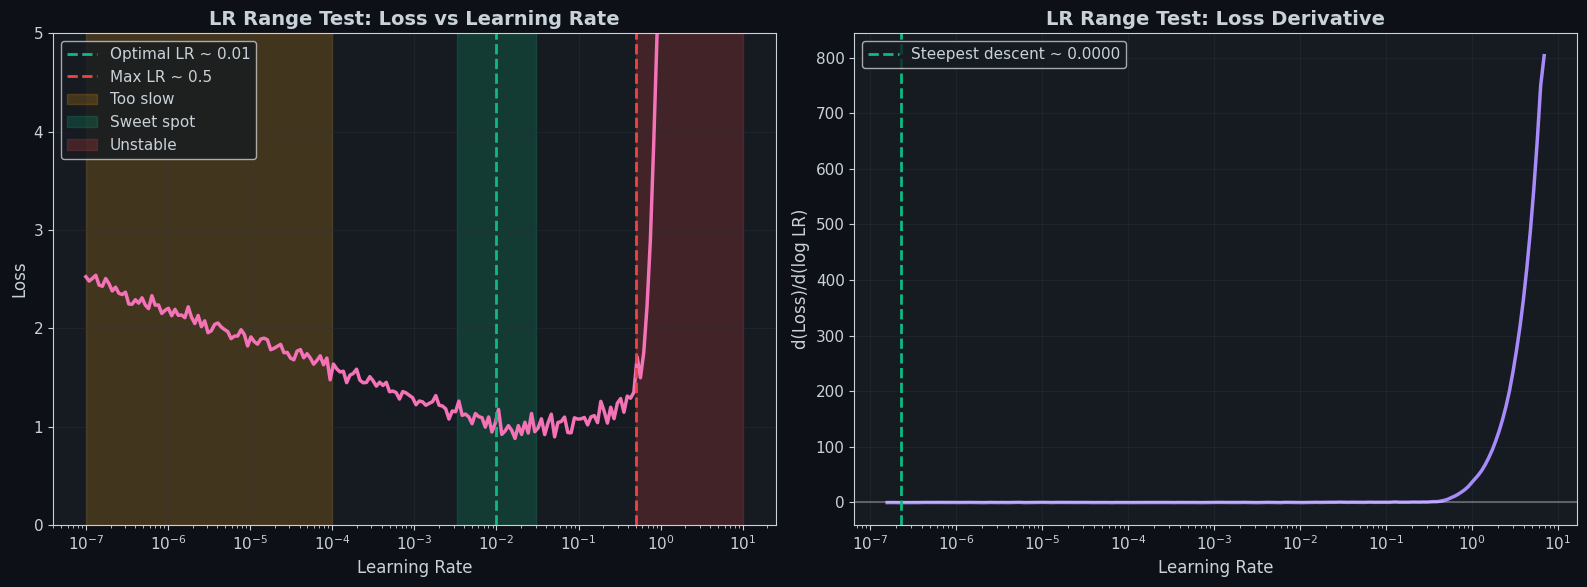


LR RANGE TEST INTERPRETATION:
   - Optimal LR (steepest descent): ~0.0000
   - Maximum LR (before explosion): ~0.5
   - For 1Cycle: use max_lr = 0.250 to 0.500
   - For standard training: start with LR = 0.0100


In [ ]:
# Implementation: Learning Rate Range Test

def lr_range_test_simulation():
    """Simulate an LR range test to show how to find optimal LR."""

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.patch.set_facecolor('#0d1117')

    # Simulate LR range test
    np.random.seed(42)

    # Learning rates from 1e-7 to 10
    lrs = np.logspace(-7, 1, 200)

    # Simulate loss response to different learning rates
    # Loss decreases until optimal LR, then increases/explodes
    optimal_lr = 0.01
    explosion_lr = 0.5

    losses = []
    base_loss = 2.5

    for i, lr in enumerate(lrs):
        if lr < optimal_lr:
            # Loss decreases slowly with very small LR, faster as LR increases
            progress = np.log10(lr / 1e-7) / np.log10(optimal_lr / 1e-7)
            loss = base_loss - 1.5 * progress + np.random.randn() * 0.05
        elif lr < explosion_lr:
            # Near optimal - loss is low but stable
            progress = (lr - optimal_lr) / (explosion_lr - optimal_lr)
            loss = 1.0 + 0.3 * progress + np.random.randn() * 0.08
        else:
            # LR too high - loss explodes
            explosion_factor = (lr - explosion_lr) / explosion_lr
            loss = 1.3 + 5 * explosion_factor ** 1.5 + np.random.randn() * 0.2

        losses.append(max(0.5, loss))

    losses = np.array(losses)

    # Plot 1: Loss vs LR
    ax1 = axes[0]
    ax1.plot(lrs, losses, color=COLORS['loss'], linewidth=2.5)
    ax1.set_xscale('log')
    ax1.set_xlabel('Learning Rate')
    ax1.set_ylabel('Loss')
    ax1.set_title('LR Range Test: Loss vs Learning Rate', fontweight='bold')

    # Mark important regions
    ax1.axvline(x=optimal_lr, color=COLORS['optimal'], linestyle='--', linewidth=2, label=f'Optimal LR ~ {optimal_lr}')
    ax1.axvline(x=explosion_lr, color=COLORS['too_high'], linestyle='--', linewidth=2, label=f'Max LR ~ {explosion_lr}')

    ax1.axvspan(1e-7, 1e-4, alpha=0.2, color=COLORS['too_low'], label='Too slow')
    ax1.axvspan(optimal_lr/3, optimal_lr*3, alpha=0.2, color=COLORS['optimal'], label='Sweet spot')
    ax1.axvspan(explosion_lr, 10, alpha=0.2, color=COLORS['too_high'], label='Unstable')

    ax1.legend(loc='upper left')
    ax1.set_ylim(0, 5)

    # Plot 2: Loss derivative (rate of change)
    ax2 = axes[1]

    # Compute smoothed derivative
    window = 10
    smoothed_losses = np.convolve(losses, np.ones(window)/window, mode='valid')
    smoothed_lrs = lrs[window//2:-window//2+1]

    derivative = np.gradient(smoothed_losses, np.log10(smoothed_lrs))

    ax2.plot(smoothed_lrs, derivative, color=COLORS['cosine'], linewidth=2.5)
    ax2.set_xscale('log')
    ax2.set_xlabel('Learning Rate')
    ax2.set_ylabel('d(Loss)/d(log LR)')
    ax2.set_title('LR Range Test: Loss Derivative', fontweight='bold')
    ax2.axhline(y=0, color='white', linestyle='-', alpha=0.3)

    # Mark steepest descent
    min_derivative_idx = np.argmin(derivative)
    steepest_lr = smoothed_lrs[min_derivative_idx]
    ax2.axvline(x=steepest_lr, color=COLORS['optimal'], linestyle='--', linewidth=2,
               label=f'Steepest descent ~ {steepest_lr:.4f}')
    ax2.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    print("\nLR RANGE TEST INTERPRETATION:")
    print(f"   - Optimal LR (steepest descent): ~{steepest_lr:.4f}")
    print(f"   - Maximum LR (before explosion): ~{explosion_lr}")
    print(f"   - For 1Cycle: use max_lr = {explosion_lr/2:.3f} to {explosion_lr:.3f}")
    print(f"   - For standard training: start with LR = {optimal_lr:.4f}")

lr_range_test_simulation()

---

## Part 7: Transformer Learning Rate Schedule

### The Original Transformer Schedule (Vaswani et al., 2017)

$$\eta = d_{model}^{-0.5} \cdot \min(step^{-0.5}, step \cdot warmup\_steps^{-1.5})$$

This combines:
1. **Linear warmup** for the first `warmup_steps`
2. **Inverse square root decay** after warmup

### Why This Works for Transformers

- Warmup stabilizes attention mechanism early on
- Inverse sqrt decay provides gradual decrease
- Scales with model dimension for proper gradient magnitudes

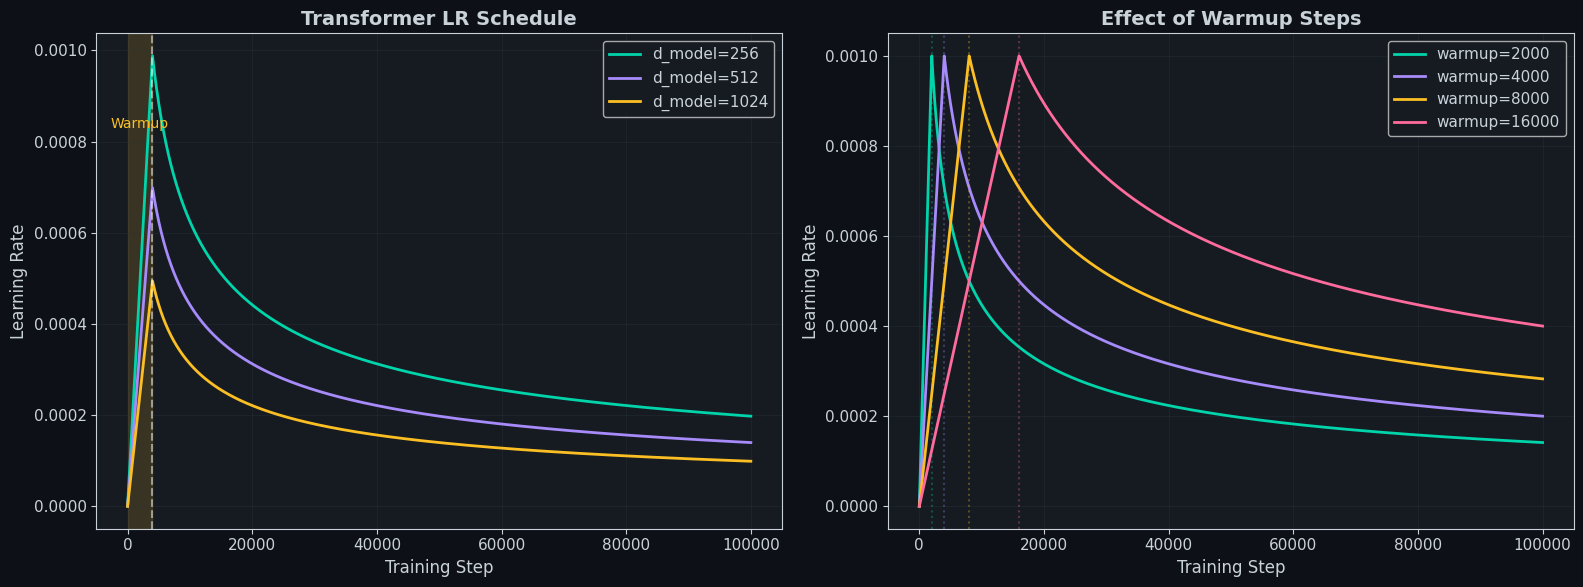


TRANSFORMER LR SCHEDULE:
   - Warmup for 4000-10000 steps is typical
   - Peak LR scales with 1/sqrt(d_model)
   - Inverse sqrt decay after warmup
   - Modern variants often use cosine decay instead


In [ ]:
# Implementation: Transformer LR Schedule

class TransformerLR:
    """Original Transformer LR Schedule (Attention Is All You Need)."""

    def __init__(self, d_model=512, warmup_steps=4000, factor=1.0):
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.factor = factor

    def get_lr(self, step):
        step = max(step, 1)
        return self.factor * (self.d_model ** -0.5) * \
               min(step ** -0.5, step * (self.warmup_steps ** -1.5))

    def get_schedule(self, total_steps):
        return np.array([self.get_lr(s) for s in range(1, total_steps + 1)])


class InverseSqrtLR:
    """Warmup + Inverse Square Root Decay."""

    def __init__(self, initial_lr, warmup_steps):
        self.initial_lr = initial_lr
        self.warmup_steps = warmup_steps

    def get_lr(self, step):
        step = max(step, 1)
        if step < self.warmup_steps:
            return self.initial_lr * step / self.warmup_steps
        else:
            return self.initial_lr * (self.warmup_steps ** 0.5) * (step ** -0.5)

    def get_schedule(self, total_steps):
        return np.array([self.get_lr(s) for s in range(1, total_steps + 1)])


# Visualization
def visualize_transformer_lr():
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.patch.set_facecolor('#0d1117')

    steps = np.arange(1, 100001)

    # Plot 1: Original Transformer Schedule
    ax1 = axes[0]

    for d_model, color in zip([256, 512, 1024], [COLORS['step'], COLORS['cosine'], COLORS['warmup']]):
        scheduler = TransformerLR(d_model=d_model, warmup_steps=4000)
        lrs = scheduler.get_schedule(100000)
        ax1.plot(steps, lrs, color=color, linewidth=2, label=f'd_model={d_model}')

    ax1.axvline(x=4000, color='white', linestyle='--', alpha=0.5)
    ax1.axvspan(0, 4000, alpha=0.15, color=COLORS['warmup'])
    ax1.text(2000, ax1.get_ylim()[1] * 0.8, 'Warmup', ha='center', fontsize=10, color=COLORS['warmup'])

    ax1.set_xlabel('Training Step')
    ax1.set_ylabel('Learning Rate')
    ax1.set_title('Transformer LR Schedule', fontweight='bold')
    ax1.legend(loc='upper right')

    # Plot 2: Different warmup steps
    ax2 = axes[1]

    warmup_vals = [2000, 4000, 8000, 16000]
    colors = [COLORS['step'], COLORS['cosine'], COLORS['warmup'], COLORS['exponential']]

    for warmup, color in zip(warmup_vals, colors):
        scheduler = InverseSqrtLR(initial_lr=0.001, warmup_steps=warmup)
        lrs = scheduler.get_schedule(100000)
        ax2.plot(steps, lrs, color=color, linewidth=2, label=f'warmup={warmup}')
        ax2.axvline(x=warmup, color=color, linestyle=':', alpha=0.3)

    ax2.set_xlabel('Training Step')
    ax2.set_ylabel('Learning Rate')
    ax2.set_title('Effect of Warmup Steps', fontweight='bold')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

visualize_transformer_lr()

print("\nTRANSFORMER LR SCHEDULE:")
print("   - Warmup for 4000-10000 steps is typical")
print("   - Peak LR scales with 1/sqrt(d_model)")
print("   - Inverse sqrt decay after warmup")
print("   - Modern variants often use cosine decay instead")

---

## Part 8: Summary and Comparison

### Quick Reference Guide

| Task | Recommended Scheduler |
|------|----------------------|
| Image Classification (CNN) | Step Decay or Cosine |
| Transformers/NLP | Warmup + Cosine or Warmup + InvSqrt |
| Fine-tuning | Cosine (small LR) |
| Fast Training | 1Cycle |
| Object Detection | Step Decay with milestones |
| General Purpose | Warmup + Cosine |

### Best Practices

1. **Always use warmup** with large learning rates or batch sizes
2. **Run LR range test** to find optimal learning rate
3. **Cosine annealing** is a safe default choice
4. **Monitor validation loss** to detect if LR is too high/low
5. **Consider 1Cycle** for faster training

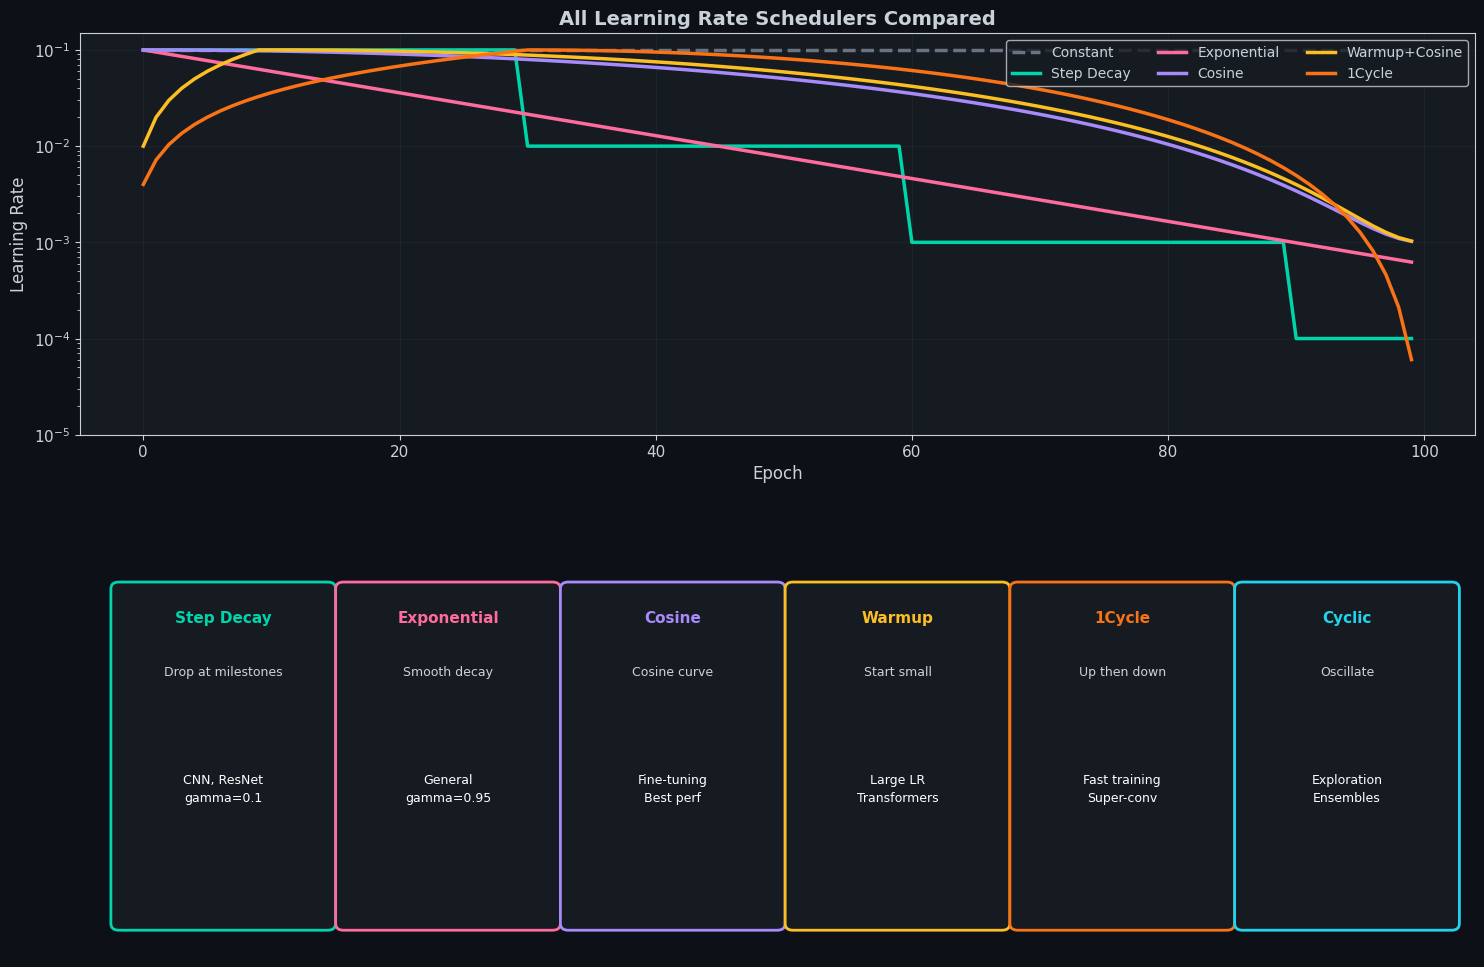

In [ ]:
# Final Comprehensive Comparison

def create_comprehensive_comparison():
    fig = plt.figure(figsize=(18, 12))
    fig.patch.set_facecolor('#0d1117')

    gs = fig.add_gridspec(2, 1, height_ratios=[1, 1], hspace=0.3)

    # Top: All schedulers comparison
    ax1 = fig.add_subplot(gs[0])

    epochs = np.arange(100)

    schedulers = {
        'Constant': (np.ones(100) * 0.1, COLORS['constant'], '--'),
        'Step Decay': (MultiStepLR(0.1, [30, 60, 90], 0.1).get_schedule(100), COLORS['step'], '-'),
        'Exponential': (ExponentialLR(0.1, 0.95).get_schedule(100), COLORS['exponential'], '-'),
        'Cosine': (CosineAnnealingLR(0.1, 100, 0.001).get_schedule(), COLORS['cosine'], '-'),
        'Warmup+Cosine': (LinearWarmup(0.1, 10, 100, 'cosine', 0.001).get_schedule(), COLORS['warmup'], '-'),
        '1Cycle': (OneCycleLR(0.1, 100).get_schedule(), COLORS['onecycle'], '-'),
    }

    for name, (schedule, color, linestyle) in schedulers.items():
        ax1.plot(epochs, schedule, color=color, linewidth=2.5,
                label=name, linestyle=linestyle)

    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Learning Rate', fontsize=12)
    ax1.set_title('All Learning Rate Schedulers Compared', fontweight='bold', fontsize=14)
    ax1.legend(loc='upper right', ncol=3, fontsize=10)
    ax1.set_yscale('log')
    ax1.set_ylim(1e-5, 0.15)

    # Bottom: Summary cards
    ax2 = fig.add_subplot(gs[1])
    ax2.set_xlim(0, 18)
    ax2.set_ylim(0, 6)
    ax2.axis('off')

    techniques = [
        ('Step Decay', 'Drop at milestones', 'CNN, ResNet\ngamma=0.1', COLORS['step']),
        ('Exponential', 'Smooth decay', 'General\ngamma=0.95', COLORS['exponential']),
        ('Cosine', 'Cosine curve', 'Fine-tuning\nBest perf', COLORS['cosine']),
        ('Warmup', 'Start small', 'Large LR\nTransformers', COLORS['warmup']),
        ('1Cycle', 'Up then down', 'Fast training\nSuper-conv', COLORS['onecycle']),
        ('Cyclic', 'Oscillate', 'Exploration\nEnsembles', COLORS['cyclic']),
    ]

    for idx, (title, subtitle, use_case, color) in enumerate(techniques):
        x = 0.5 + idx * 2.9

        rect = FancyBboxPatch((x, 0.5), 2.7, 5,
                              boxstyle="round,pad=0.1",
                              facecolor='#161b22', edgecolor=color, linewidth=2)
        ax2.add_patch(rect)

        ax2.text(x + 1.35, 5, title, ha='center', fontsize=11, fontweight='bold', color=color)
        ax2.text(x + 1.35, 4.2, subtitle, ha='center', fontsize=9, color='white', alpha=0.8)
        ax2.text(x + 1.35, 2.5, use_case, ha='center', fontsize=9, color='white',
                linespacing=1.5, va='center')

    plt.tight_layout()
    plt.show()

create_comprehensive_comparison()

In [ ]:
# PyTorch Implementation Examples

pytorch_code = '''
import torch.optim as optim
from torch.optim.lr_scheduler import (
    StepLR, MultiStepLR, ExponentialLR, CosineAnnealingLR,
    CosineAnnealingWarmRestarts, OneCycleLR, ReduceLROnPlateau,
    CyclicLR, LambdaLR
)

optimizer = optim.Adam(model.parameters(), lr=0.1)

# Step Decay
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Multi-Step
scheduler = MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.1)

# Exponential
scheduler = ExponentialLR(optimizer, gamma=0.95)

# Cosine Annealing
scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=0.001)

# Cosine with Warm Restarts (SGDR)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=2)

# 1Cycle
scheduler = OneCycleLR(optimizer, max_lr=0.1,
                       total_steps=len(train_loader) * num_epochs)

# Reduce on Plateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1)

# Linear Warmup + Cosine (custom)
warmup_epochs = 10
total_epochs = 100

def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return epoch / warmup_epochs
    progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
    return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = LambdaLR(optimizer, lr_lambda)

# Training loop
for epoch in range(num_epochs):
    train_one_epoch()
    val_loss = validate()

    # For most schedulers:
    scheduler.step()

    # For ReduceLROnPlateau:
    # scheduler.step(val_loss)

    # For OneCycleLR (step per batch):
    # for batch in train_loader:
    #     train_batch(batch)
    #     scheduler.step()
'''

print("PyTorch Implementation Examples:")
print("="*60)
print(pytorch_code)

PyTorch Implementation Examples:

import torch.optim as optim
from torch.optim.lr_scheduler import (
    StepLR, MultiStepLR, ExponentialLR, CosineAnnealingLR,
    CosineAnnealingWarmRestarts, OneCycleLR, ReduceLROnPlateau,
    CyclicLR, LambdaLR
)

optimizer = optim.Adam(model.parameters(), lr=0.1)

# Step Decay
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Multi-Step
scheduler = MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.1)

# Exponential
scheduler = ExponentialLR(optimizer, gamma=0.95)

# Cosine Annealing
scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=0.001)

# Cosine with Warm Restarts (SGDR)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=2)

# 1Cycle
scheduler = OneCycleLR(optimizer, max_lr=0.1, 
                       total_steps=len(train_loader) * num_epochs)

# Reduce on Plateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1)

# Linear Warmup + Cosine (custom)
warmup_epochs = 10
total_epochs

---

## Summary

### Key Takeaways

1. **Learning rate scheduling is essential** for optimal training
   - Too high LR leads to oscillation and divergence
   - Too low LR leads to slow convergence
   - Scheduled LR provides the best of both worlds

2. **Step Decay**: Simple and effective
   - Drop by factor gamma every N epochs
   - Common: gamma=0.1 at epochs 30, 60, 90

3. **Exponential Decay**: Smooth continuous decay
   - LR = LR_0 * gamma^epoch
   - gamma = 0.95-0.99 typical

4. **Cosine Annealing**: Often best performance
   - Smooth cosine curve
   - Gentle at start and end, faster in middle
   - SGDR: with warm restarts for escaping local minima

5. **Warmup**: Stabilize early training
   - Start small, increase to target LR
   - Critical for large learning rates and batch sizes
   - Essential for Transformers

6. **1Cycle**: Super-convergence for fast training
   - Increase then decrease LR
   - Can train faster with higher max LR

7. **LR Range Test**: Find optimal learning rate empirically

### Default Recommendations

- **Safe default**: Warmup (5-10%) + Cosine Annealing
- **Fast training**: 1Cycle
- **Classic CNN**: Step Decay at 1/3 and 2/3 of training
- **Transformers**: Warmup + Cosine or Warmup + InvSqrt

---

## References

1. Loshchilov & Hutter (2016): "SGDR: Stochastic Gradient Descent with Warm Restarts"
2. Smith (2017): "Cyclical Learning Rates for Training Neural Networks"
3. Smith & Topin (2018): "Super-Convergence: Very Fast Training Using Large Learning Rates"
4. Vaswani et al. (2017): "Attention Is All You Need"
5. Goyal et al. (2017): "Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour"

---

**End of Notebook**